## Libraries

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.insert(1, '../')
from glob import glob
import helpers.dataset_stats as ds
import helpers.convergence_stats as cs
import helpers.scalability_stats as ss
import helpers.sig_freq_itemsets_analyzer as sig
import helpers.numfreqitemsets_stats as ns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import combinations

In [4]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.spines.top'] = 'False'
matplotlib.rcParams['axes.spines.right'] = 'False'
matplotlib.rcParams['axes.spines.left'] = 'False'
matplotlib.rcParams['axes.spines.bottom'] = 'False'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.grid.axis'] = 'y'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20 
matplotlib.rcParams['legend.markerscale'] = 2
matplotlib.rcParams['legend.fontsize'] = 18 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

/var/folders/2q/_5nlf385019g2f7b2thjfwdh_x8ppd/T/ipykernel_58722/790388694.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [5]:
palette = sns.color_palette(['#BA1200', '#031927', '#9DD1F1', '#85CB33', '#AE759F'])

In [35]:
sns.set_theme(style='whitegrid', context='talk')

In [7]:
datasets = ['BMS1', 'BMS2', 'chess', 'foodmart', 'mushrooms', 'pumsb', 'retail']

In [8]:
samplers = ['GmmtSampler', 'caterpillars.samplers.NaiveBJDMSampler', 
            'caterpillars.samplers.CurveballBJDMSampler']
sampler_names = {'GmmtSampler' : 'GMMT',
                 'diffusr.samplers.GmmtSampler': 'GMMT',
                 'caterpillars.samplers.NaiveBJDMSampler' : 'RSO',
                 'caterpillars.samplers.CurveballBJDMSampler' : 'ALICE'}

In [9]:
data_dir = '../datasets/'
fig_dir = '/Users/u0m0518/Documents/Projects/NullModels/random-butterflies/paper/figures/'

## Dataset Stats

In [10]:
stats_df = pd.DataFrame()
for dataset in datasets:
    stats = ds.get_dataset_stats(data_dir, dataset)
    stats_df = stats_df.append([stats])

In [11]:
stats_df.columns = ['DataSet', 'Transaction Num', 'Item Num', 
                    'Sum Transaction Lengths',   'AVG Transaction Length', 
                    'Density']

In [12]:
print(stats_df.to_latex(index=False, float_format="%.4f", column_format='lrrrrr',
                        caption='Statistics of the real datasets.',
                        label='tbl:datasets', position='!ht'))

\begin{table}[!ht]
\centering
\caption{Statistics of the real datasets.}
\label{tbl:datasets}
\begin{tabular}{lrrrrr}
\toprule
  DataSet &  Transaction Num &  Item Num &  Sum Transaction Lengths &  AVG Transaction Length &  Density \\
\midrule
     BMS1 &            59602 &       497 &                   149639 &                  2.5106 &   0.0051 \\
     BMS2 &            77512 &      3340 &                   358278 &                  4.6222 &   0.0014 \\
    chess &             3196 &        75 &                   118252 &                 37.0000 &   0.4933 \\
 foodmart &             4141 &      1559 &                    18319 &                  4.4238 &   0.0028 \\
mushrooms &             8416 &       119 &                   193568 &                 23.0000 &   0.1933 \\
    pumsb &            49046 &      2113 &                  3629404 &                 74.0000 &   0.0350 \\
   retail &            88162 &     16470 &                   908576 &                 10.3058 &   0.0006 \\


### BJDM

267 3658


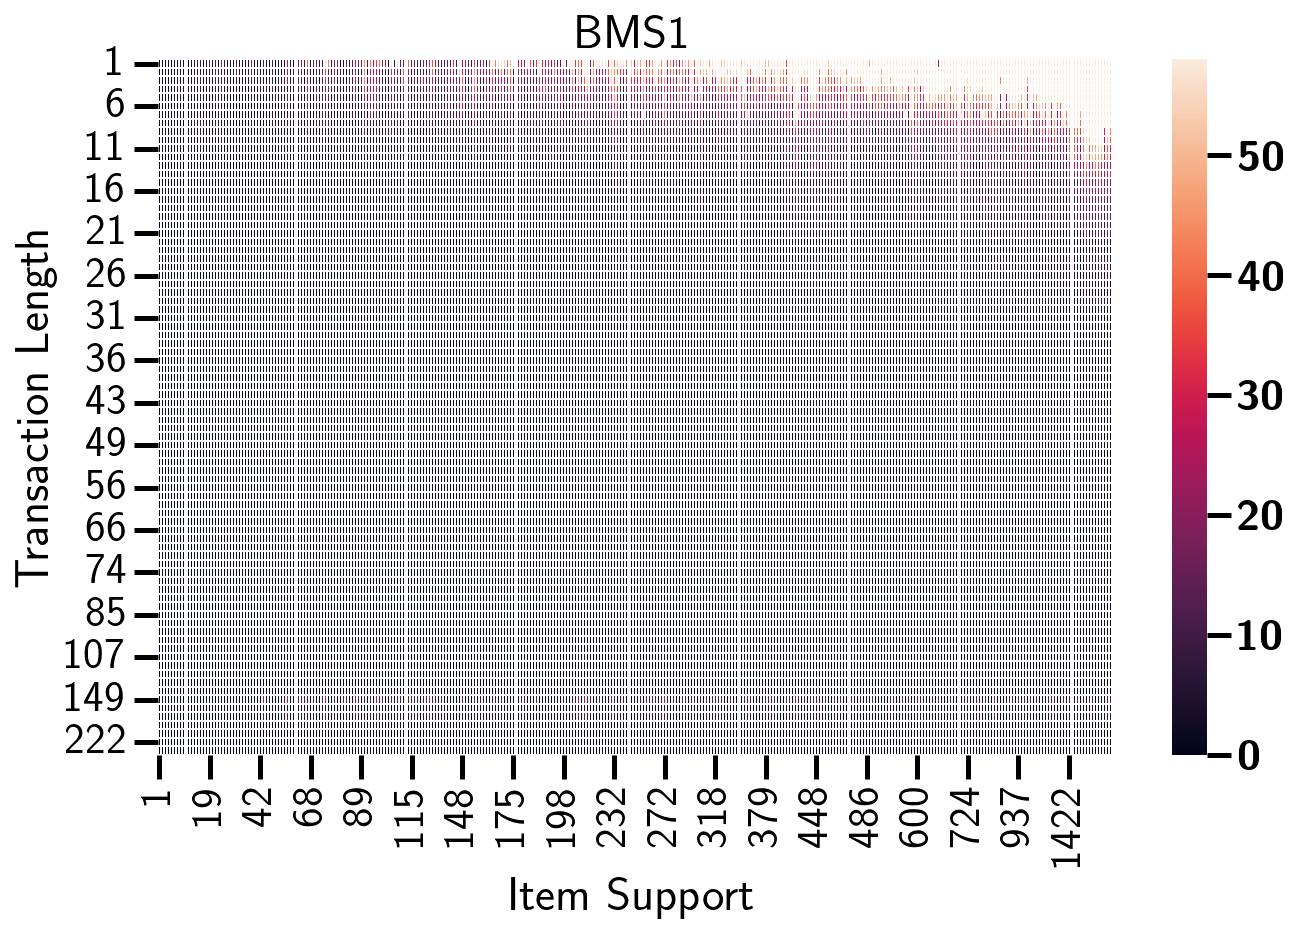

161 3766


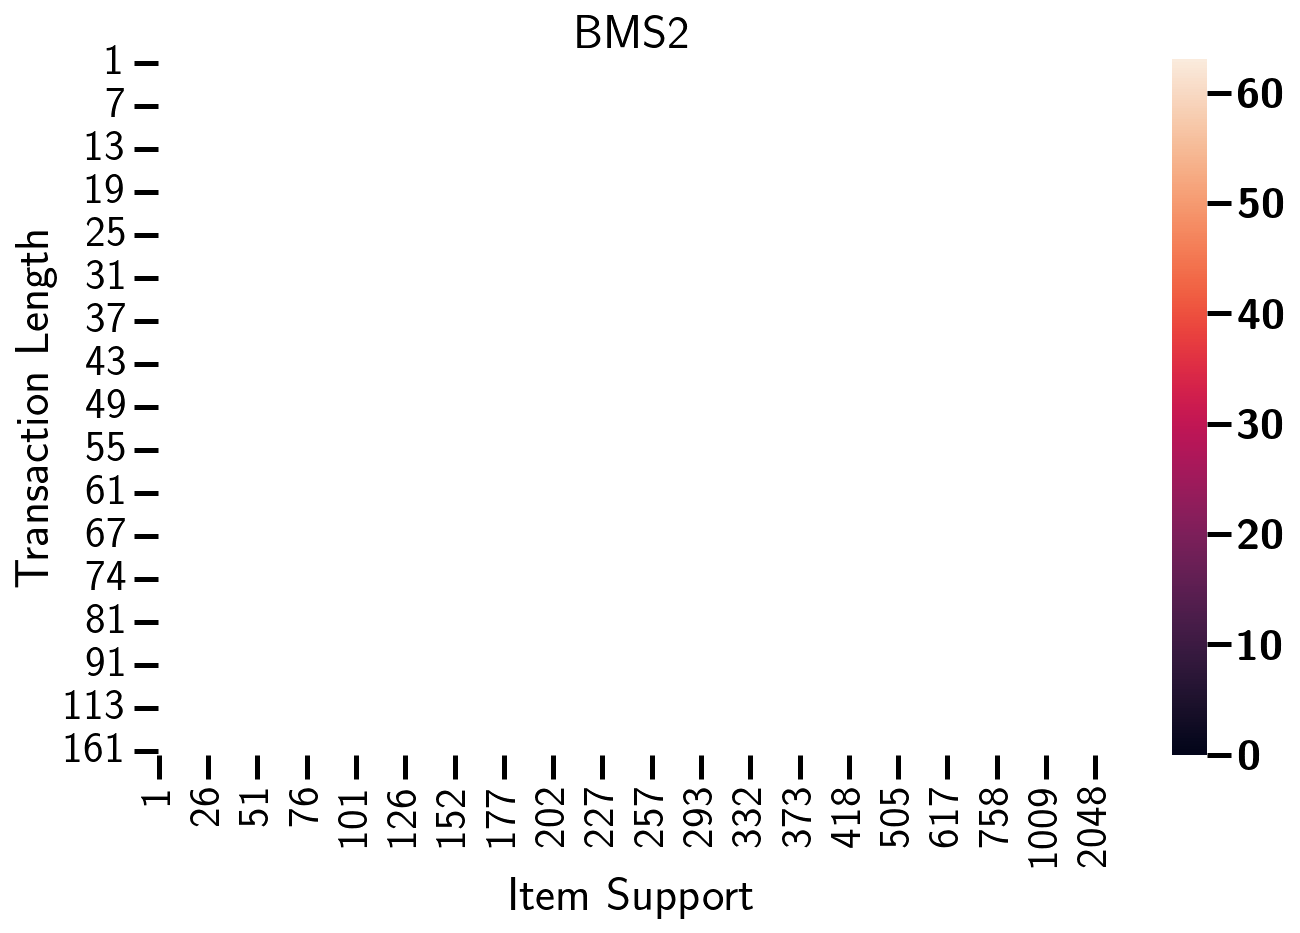

37 3195


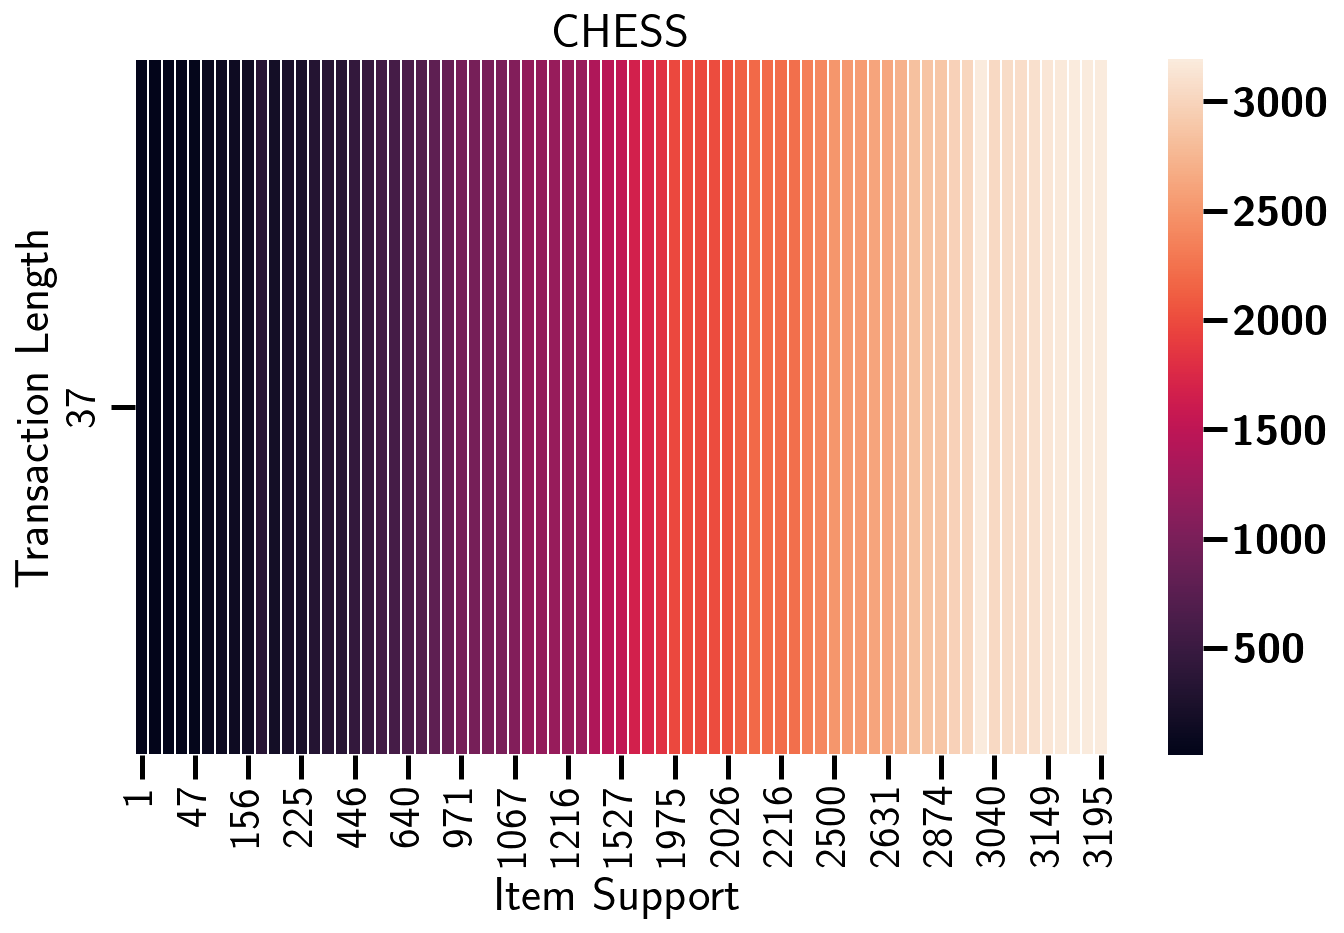

14 25


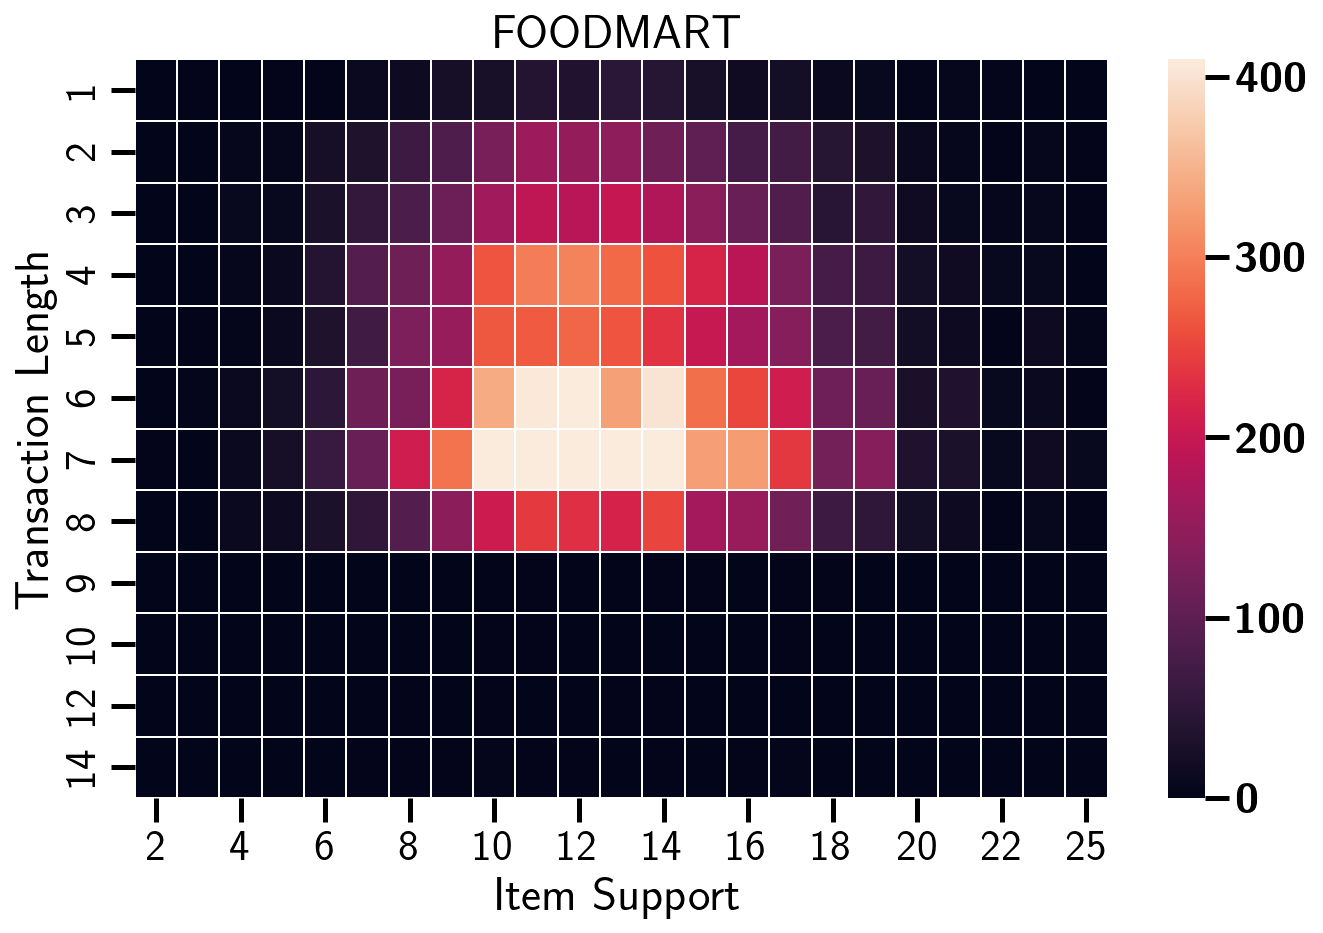

23 8416


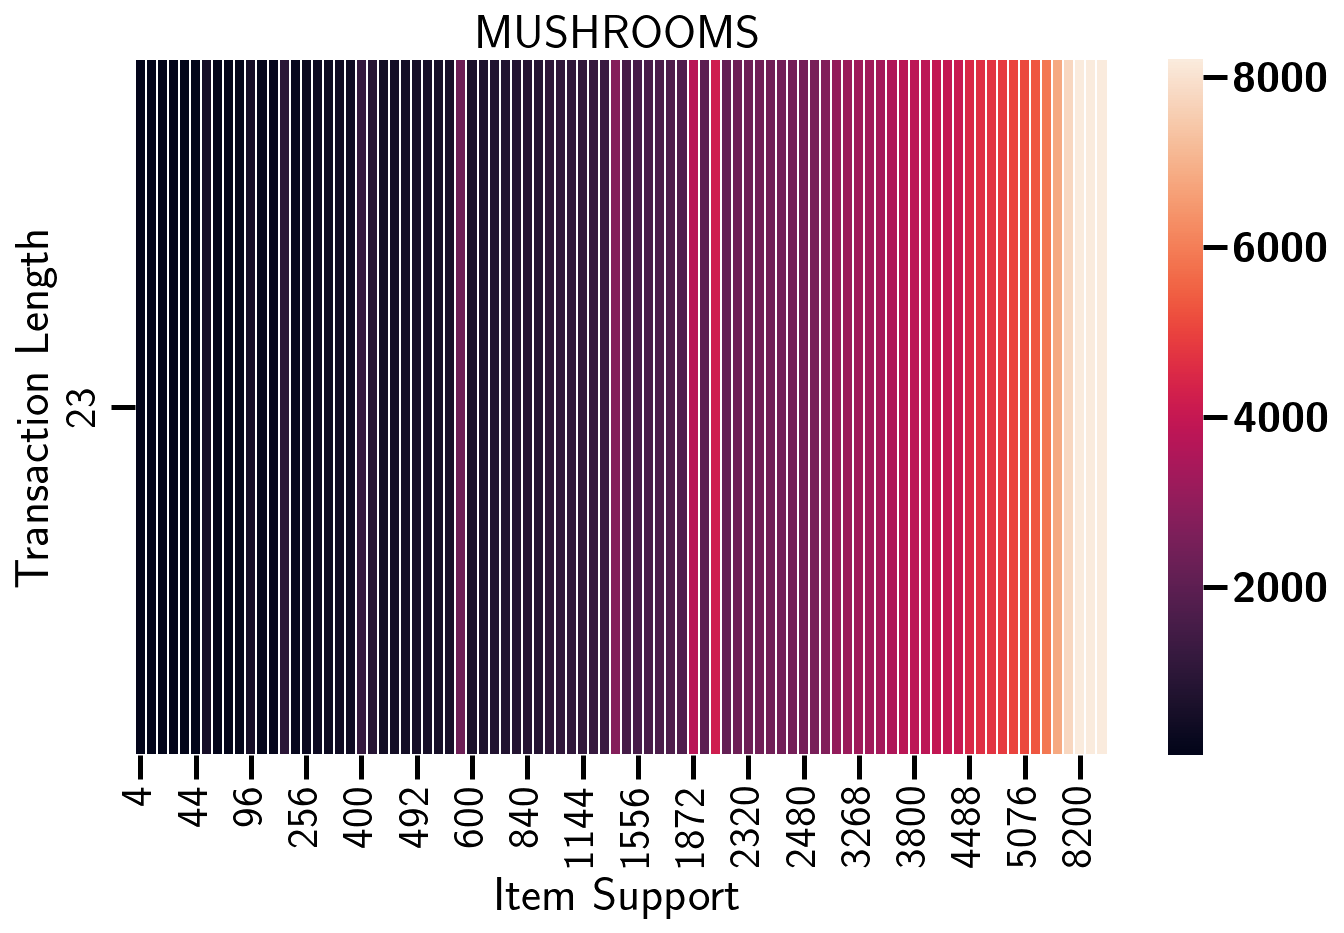

In [28]:
for dataset in ['BMS1', 'BMS2', 'chess', 'foodmart', 'mushrooms']:
    BJDM, max_len = ds.compute_BJDM(data_dir, dataset)
    bjdm_df = pd.DataFrame(BJDM)
    fig, ax = plt.subplots(figsize=(10,7))
    data = bjdm_df
    if BJDM.shape[0] == 1:
        data = bjdm_df[bjdm_df>0].T.dropna().T
    subset_c = []
    for c in data.columns:
        if data[c].sum() > 0:
            subset_c.append(c)
    subset_r = []
    for r in data.index:
        if data.loc[r].sum() > 0:
            subset_r.append(r)
    subset_data = data.loc[subset_r, subset_c]
    sns.heatmap(data=subset_data, linewidths=1, robust=True,
                ax=ax)
    ax.set_ylabel('Transaction Length')
    ax.set_xlabel('Item Support')
    x_labels = []
    for l in ax.get_xticklabels():
        x_labels.append(str(int(l.get_text())+1))
    y_labels = []
    if BJDM.shape[0] == 1:
        y_labels.append(str(max_len))
    else:
        for l in ax.get_yticklabels():
            y_labels.append(str(int(l.get_text())+1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_title(dataset.upper())
    plt.tight_layout()
    plt.show()

### Item Support

In [13]:
result_dir = '../output/significantItemsets'

In [14]:
db_config = {'foodmart':'18319-2048-128-3.0E-4-0.05-32-0',
             'chess':'118252-2048-128-0.8-0.05-32-0',
             'mushrooms':'193568-1568-128-0.3-0.05-32-0',
             'BMS1':'299278-1568-128-0.001-0.05-32-0',
             'BMS2':'716556-1568-128-0.002-0.05-32-0'}
sampler = 'caterpillars.samplers.NaiveBJDMSampler'

In [15]:
freq_it_df = pd.DataFrame()
for db,conf in db_config.items():
    try:
        file = f'{result_dir}/{db}-{sampler}-{conf}.json'
        freq_it_df = freq_it_df.append(sig.get_freq_itemsets(file, db), ignore_index=True)
    except Exception as e:
        print(e)
        pass

In [17]:
freq_it_df.groupby(by='DataSet').agg({'Support':'mean'})

,Support
DataSet,
BMS1,122.577549
BMS2,262.928591
chess,2688.501398
foodmart,5.599953
mushrooms,3098.767685


## Convergence

In [29]:
result_dir = '../output/convergence/'
# config
dbs = ['BMS1', 'BMS2', 'chess', 'foodmart', 'mushrooms']
freqs = {'BMS1':'0.001', 
         'BMS2':'0.002', 
         'chess':'0.8', 
         'foodmart':'3.0E-4', 
         'mushrooms':'0.3'}

In [30]:
conv_df = pd.DataFrame()
for db in dbs:
    file = result_dir + f'{db}-6.0-{freqs[db]}-0.json'
    tmp_df = cs.get_convergence_df(file)
    tmp_df['DataSet'] = db
    conv_df = conv_df.append(tmp_df)

In [31]:
conv_df['Algorithm'] = conv_df['Algorithm'].apply(lambda x: sampler_names[x])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


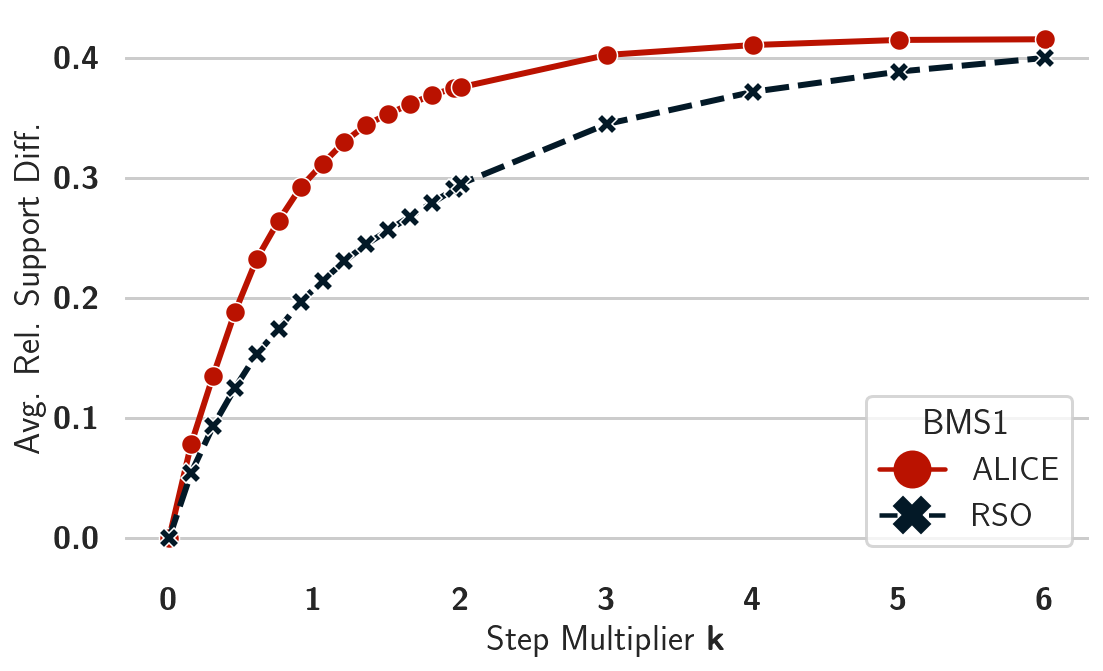

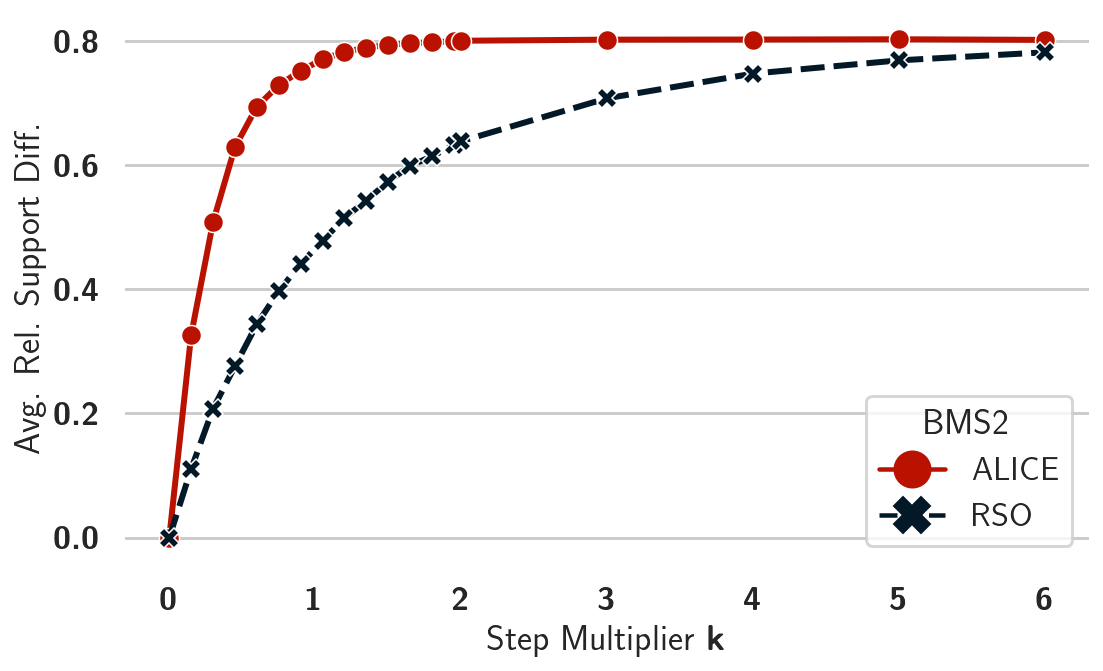

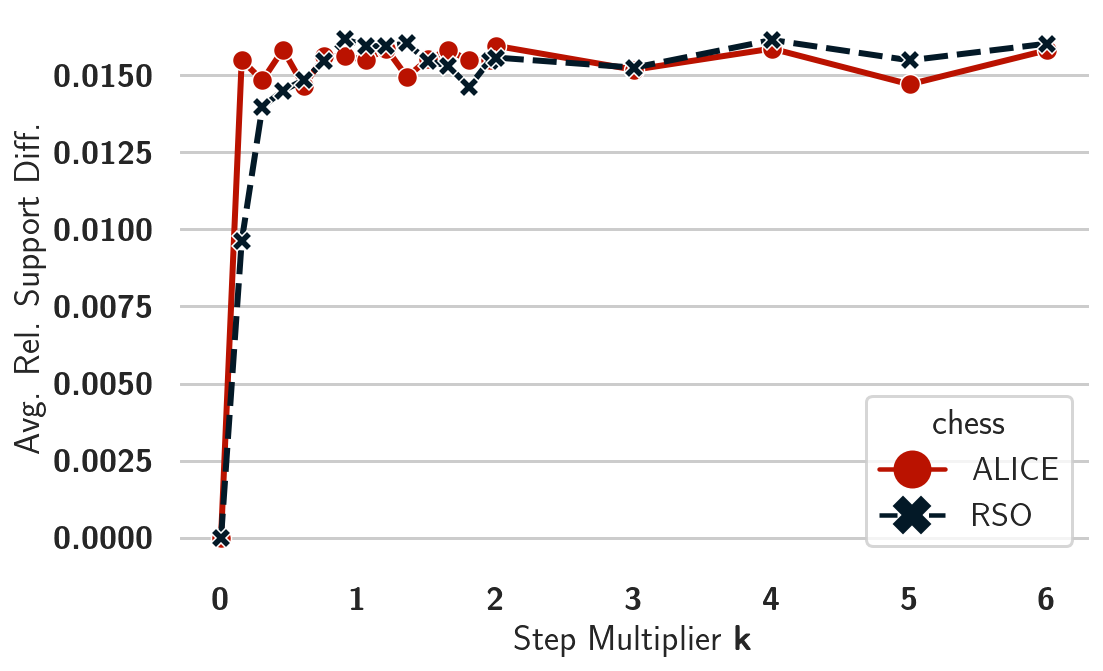

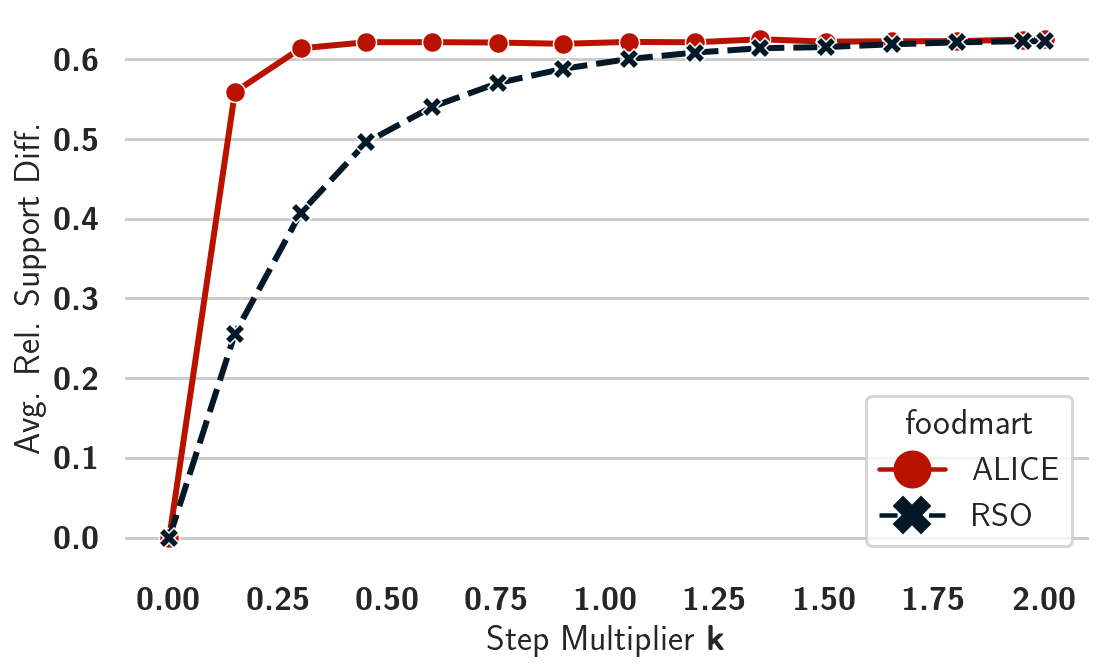

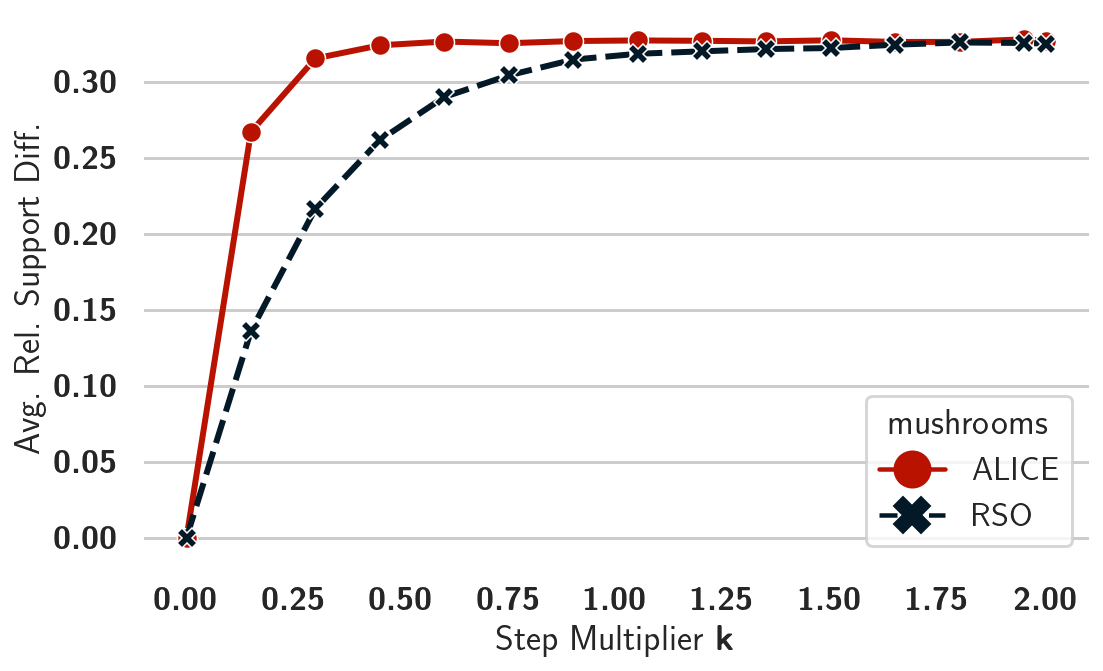

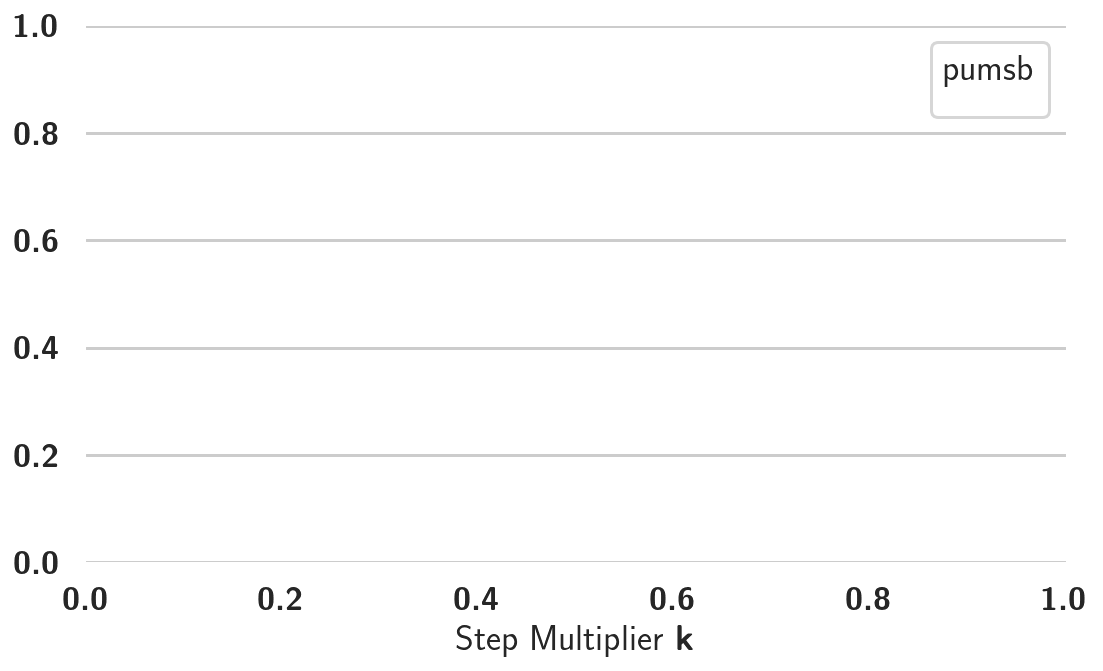

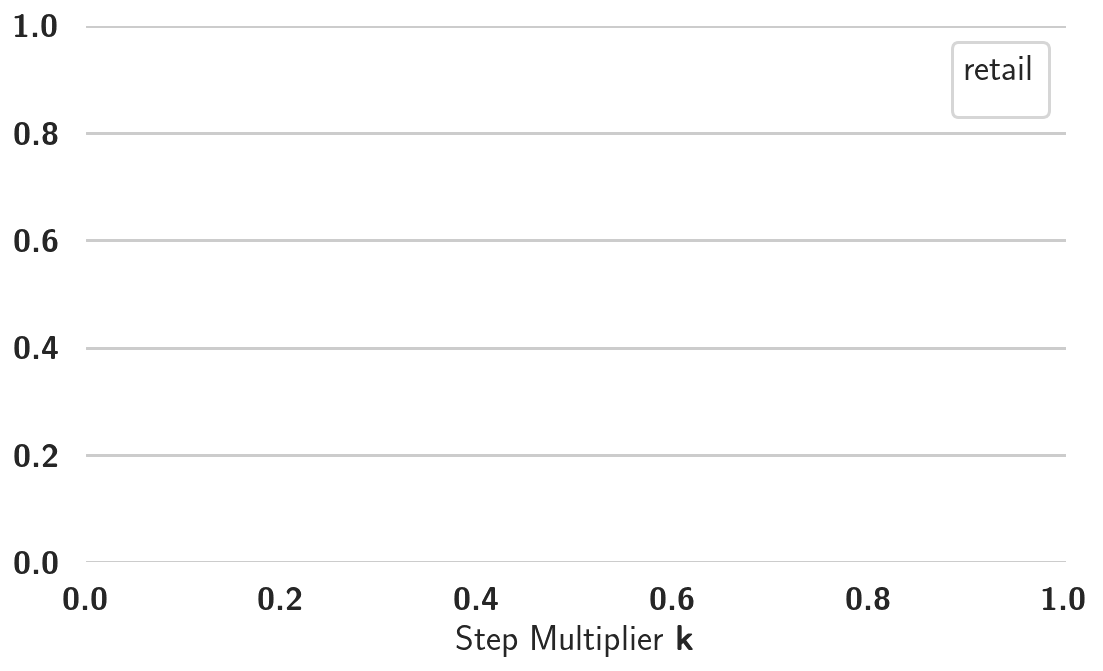

In [37]:
for dataset in datasets:
    data = conv_df[conv_df['DataSet']==dataset].sort_values(by='Algorithm').copy()
    num_colors = len(data['Algorithm'].unique())
    if dataset in ['foodmart', 'mushrooms']:
        data = data[data['Num Step Multiplier'] < 3]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.lineplot(data=data, x='Num Step Multiplier', palette=palette[:num_colors], 
                 style='Algorithm', markers=True, markersize=10, ax=ax,
                 linewidth=3, y='Avg. Rel. Support Diff.', hue='Algorithm')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlabel(r'Step Multiplier $k$')
    ax.legend(title=dataset)
    plt.tight_layout()
    plt.savefig(fig_dir+f'convergence_{dataset}.pdf')

Single plot with 3 datasets

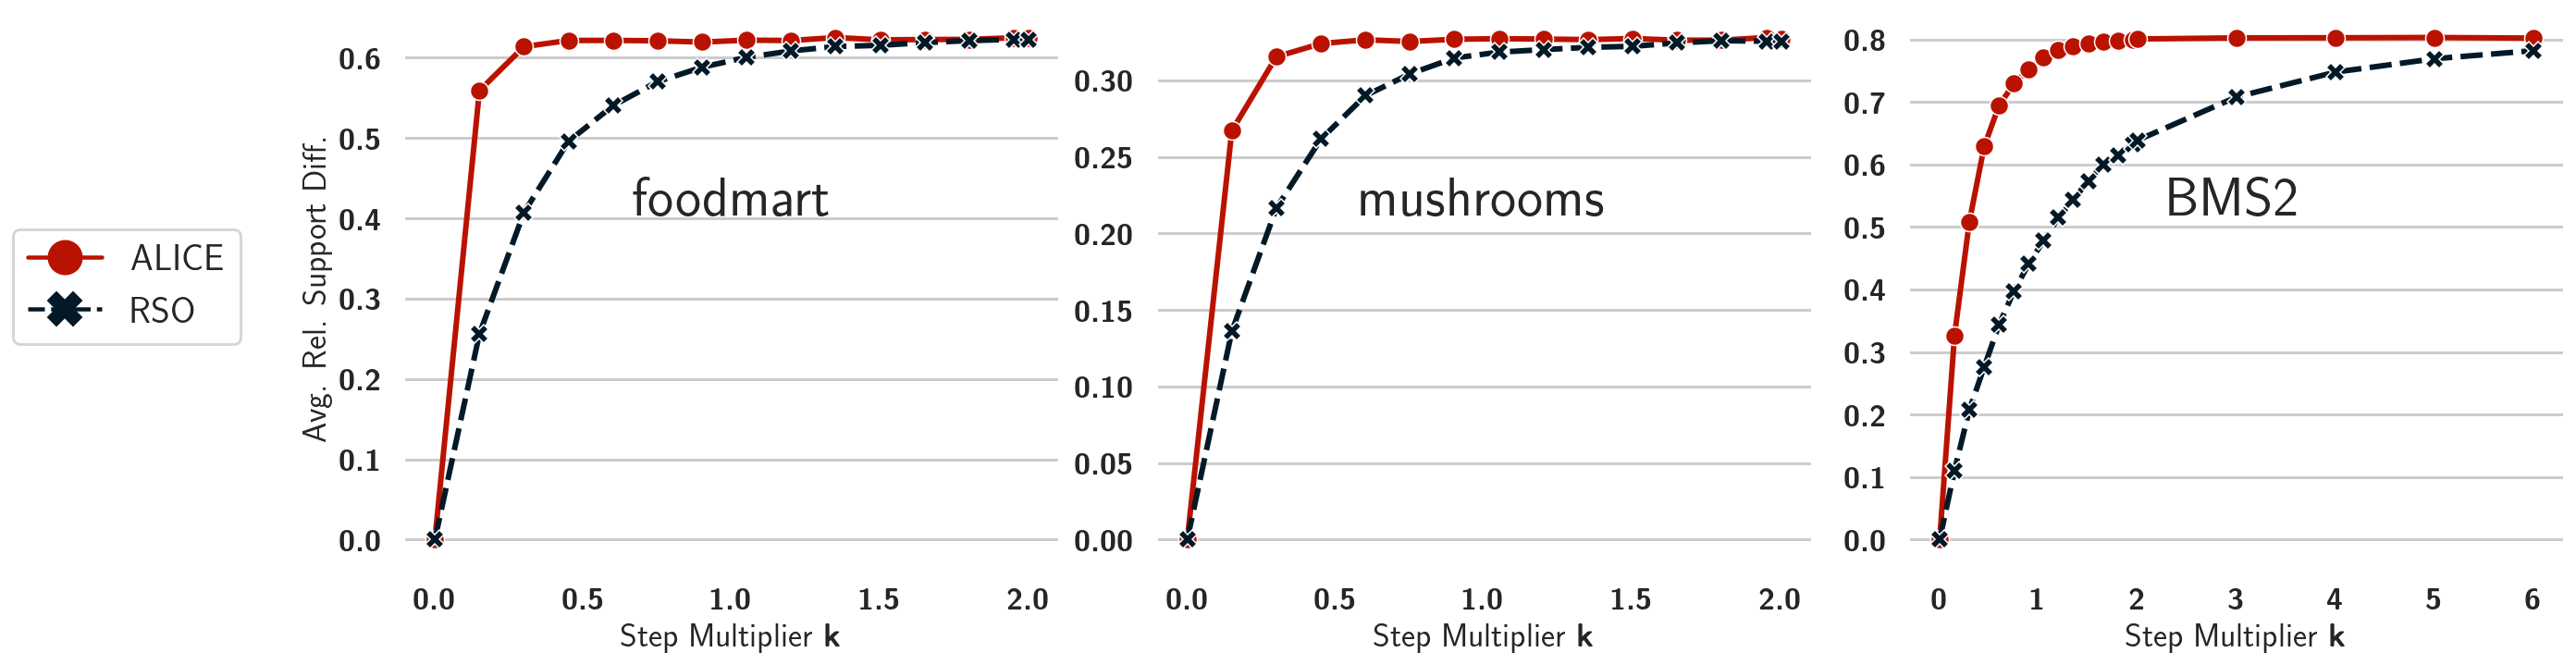

In [38]:
fig, ax = plt.subplots(1,3, figsize=(19,5))

for idx, dataset in enumerate(['foodmart', 'mushrooms', 'BMS2']):
    data = conv_df[conv_df['DataSet']==dataset].sort_values(by='Algorithm').copy()
    num_colors = len(data['Algorithm'].unique())
    if dataset in ['foodmart', 'mushrooms']:
        data = data[data['Num Step Multiplier'] < 3]
        
    sns.lineplot(data=data, x='Num Step Multiplier', palette=palette[:num_colors], 
                 style='Algorithm', markers=True, markersize=10, ax=ax[idx],
                 linewidth=3, y='Avg. Rel. Support Diff.', hue='Algorithm')
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['left'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xlabel(r'Step Multiplier $k$')
    if idx != 0:
        ax[idx].set_ylabel('')
    # legend
    leg = ax[idx].legend()
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    ax[idx].legend(loc=(-0.6,0.4), fontsize=20)
    if idx != 0:
        ax[idx].legend().remove()  
    ax[idx].set_title(dataset, fontsize=30, pad=-110)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(fig_dir+'convergence_all.pdf', bbox_inches='tight')

Time to Convergence

In [86]:
conv_time_df = conv_df.merge(stats_df[['DataSet', 'Sum Transaction Lengths']], on='DataSet')

In [87]:
conv_time_df['Time'] = conv_time_df['Setup'] + conv_time_df['Total'] 

In [88]:
conv_time_df['Time (s)'] = conv_time_df['Time'] / 1000

BMS1


,ARSD_RSO,RSO,ARSD_ALICE,ALICE
Num Step Multiplier,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.15,0.053912,0.053912,0.078034,0.078034
0.30,0.092866,0.038954,0.134837,0.056803
0.45,0.124772,0.031906,0.188007,0.053170
0.60,0.153301,0.028528,0.232504,0.044497
0.75,0.173996,0.020696,0.264448,0.031945
0.90,0.196605,0.022609,0.292144,0.027696
1.05,0.214099,0.017494,0.311646,0.019502
1.20,0.230442,0.016343,0.330225,0.018579


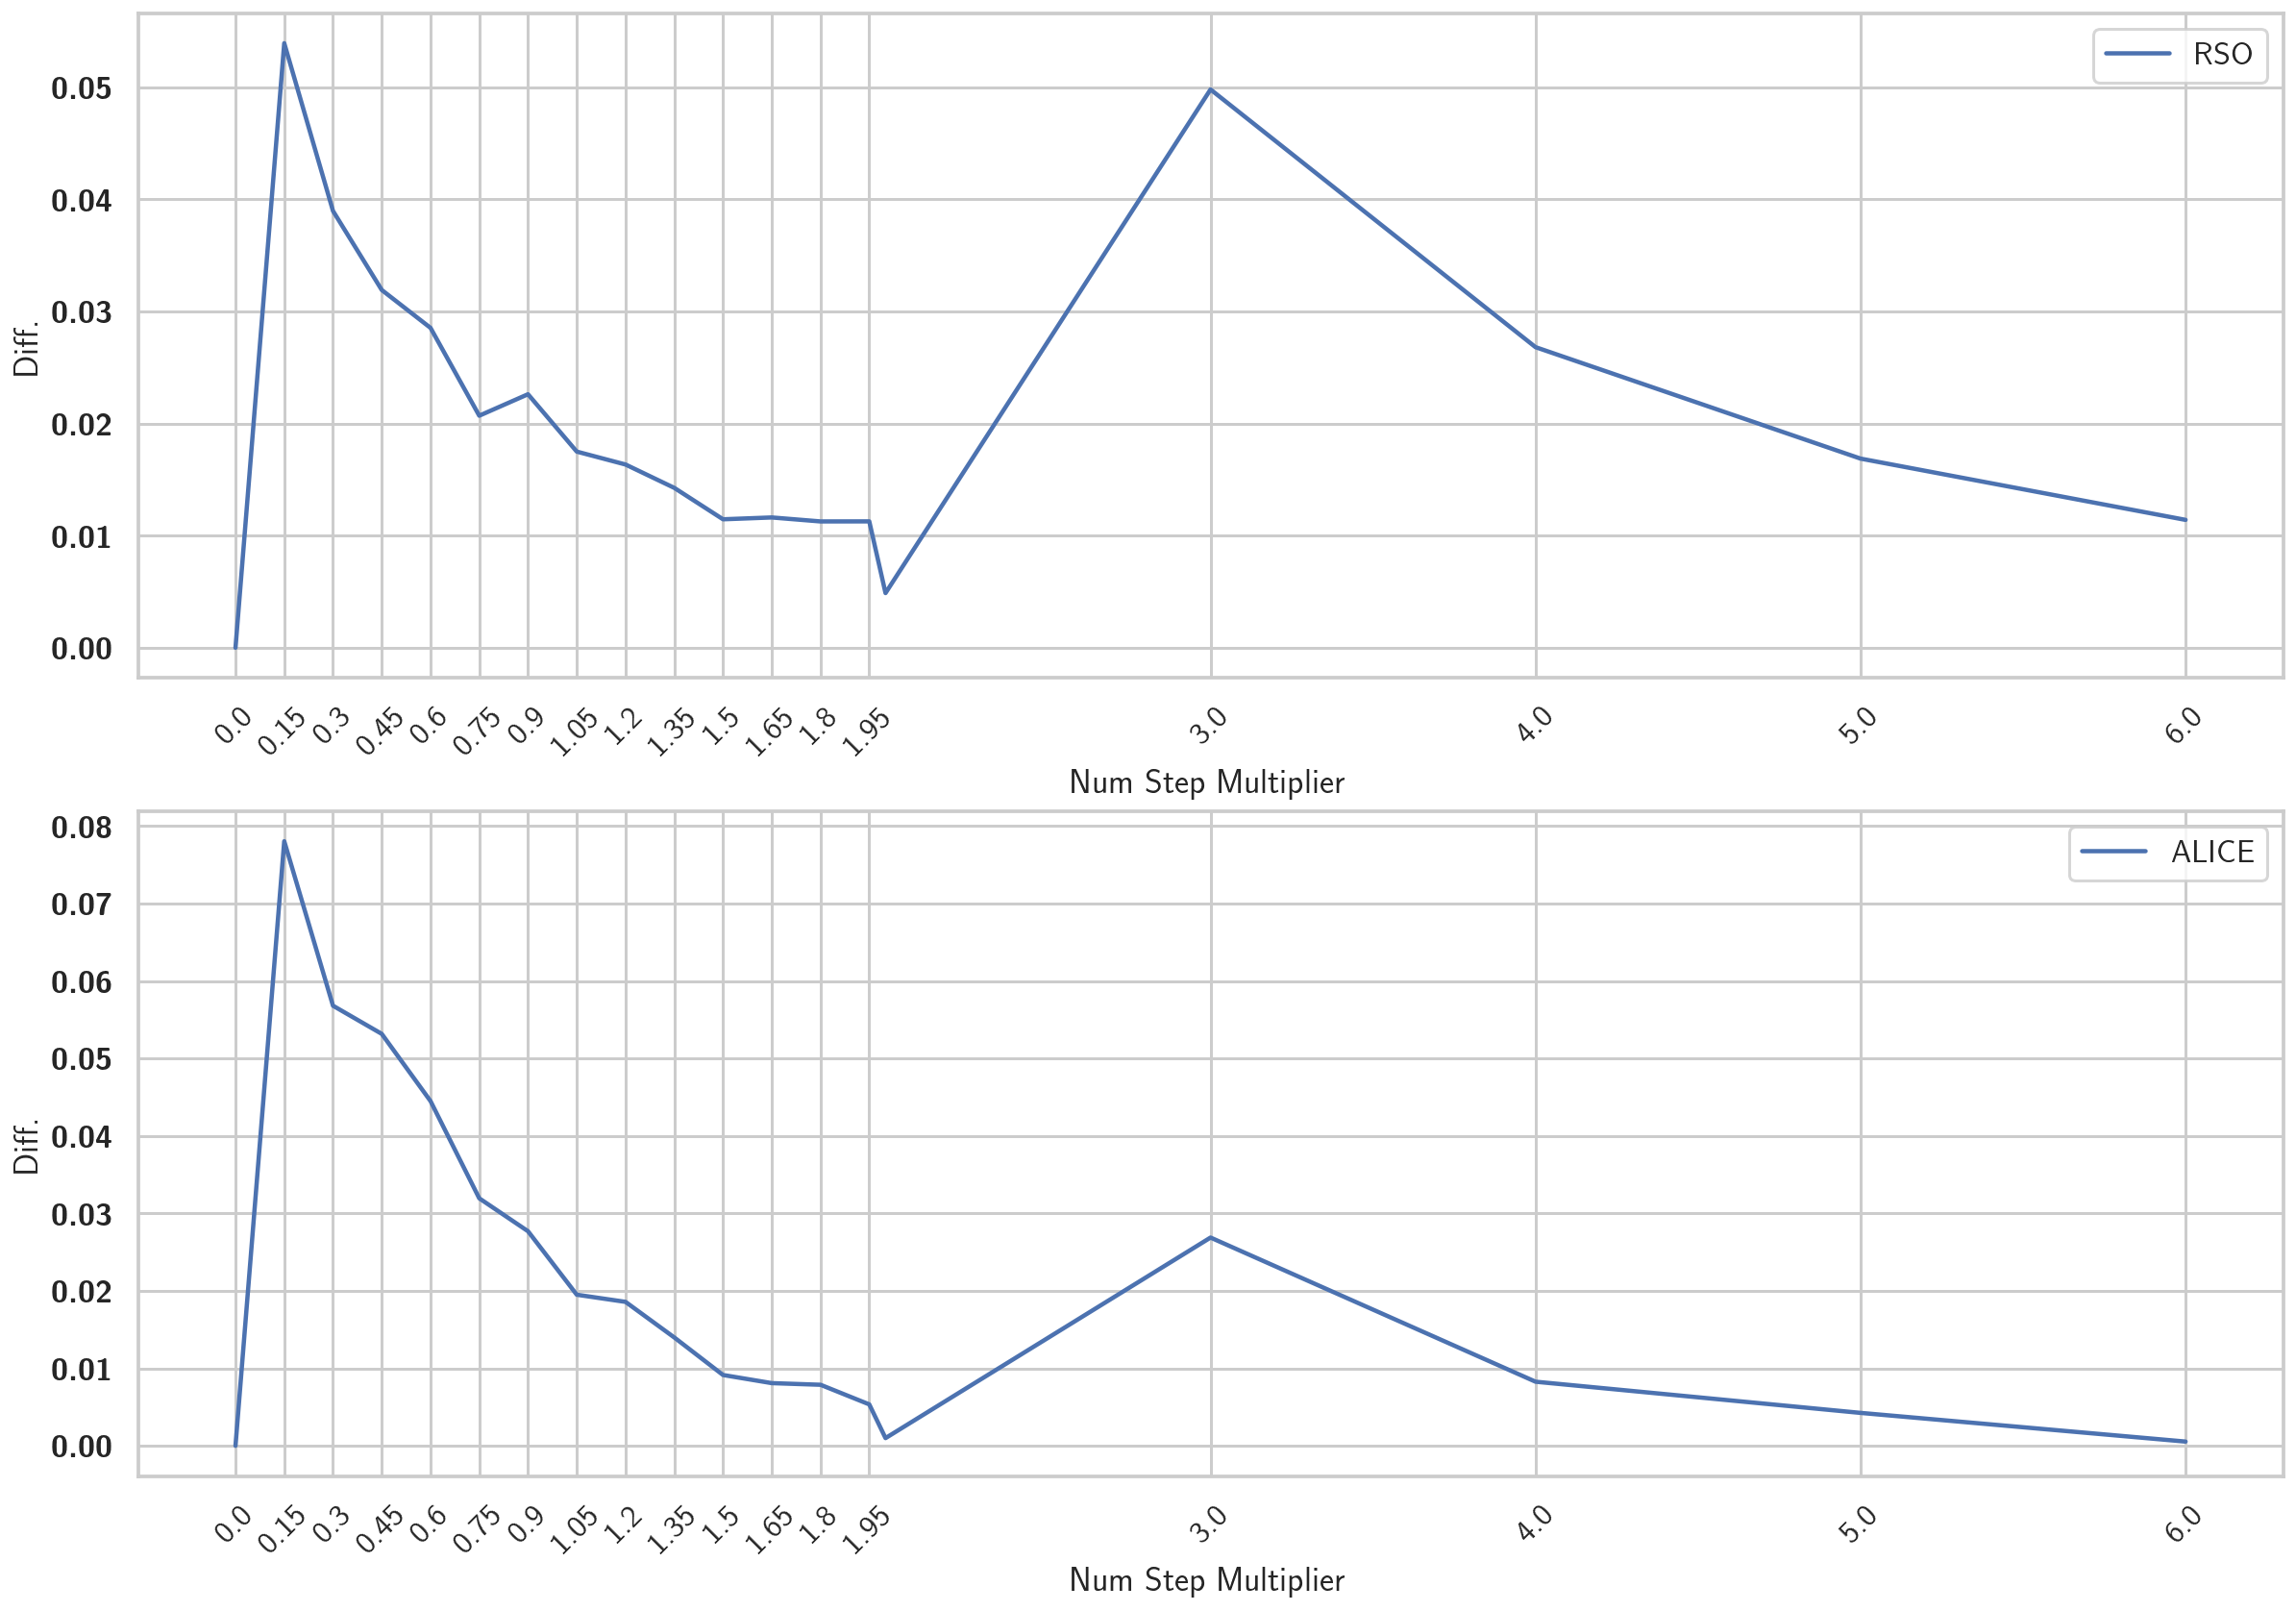

BMS2


,ARSD_RSO,RSO,ARSD_ALICE,ALICE
Num Step Multiplier,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.15,0.110616,0.110616,0.326625,0.326625
0.30,0.207596,0.096980,0.508575,0.181951
0.45,0.276155,0.068559,0.629078,0.120503
0.60,0.343695,0.067540,0.694298,0.065220
0.75,0.397200,0.053505,0.729191,0.034893
0.90,0.440910,0.043711,0.751976,0.022784
1.05,0.478253,0.037342,0.770936,0.018960
1.20,0.514986,0.036733,0.782638,0.011702


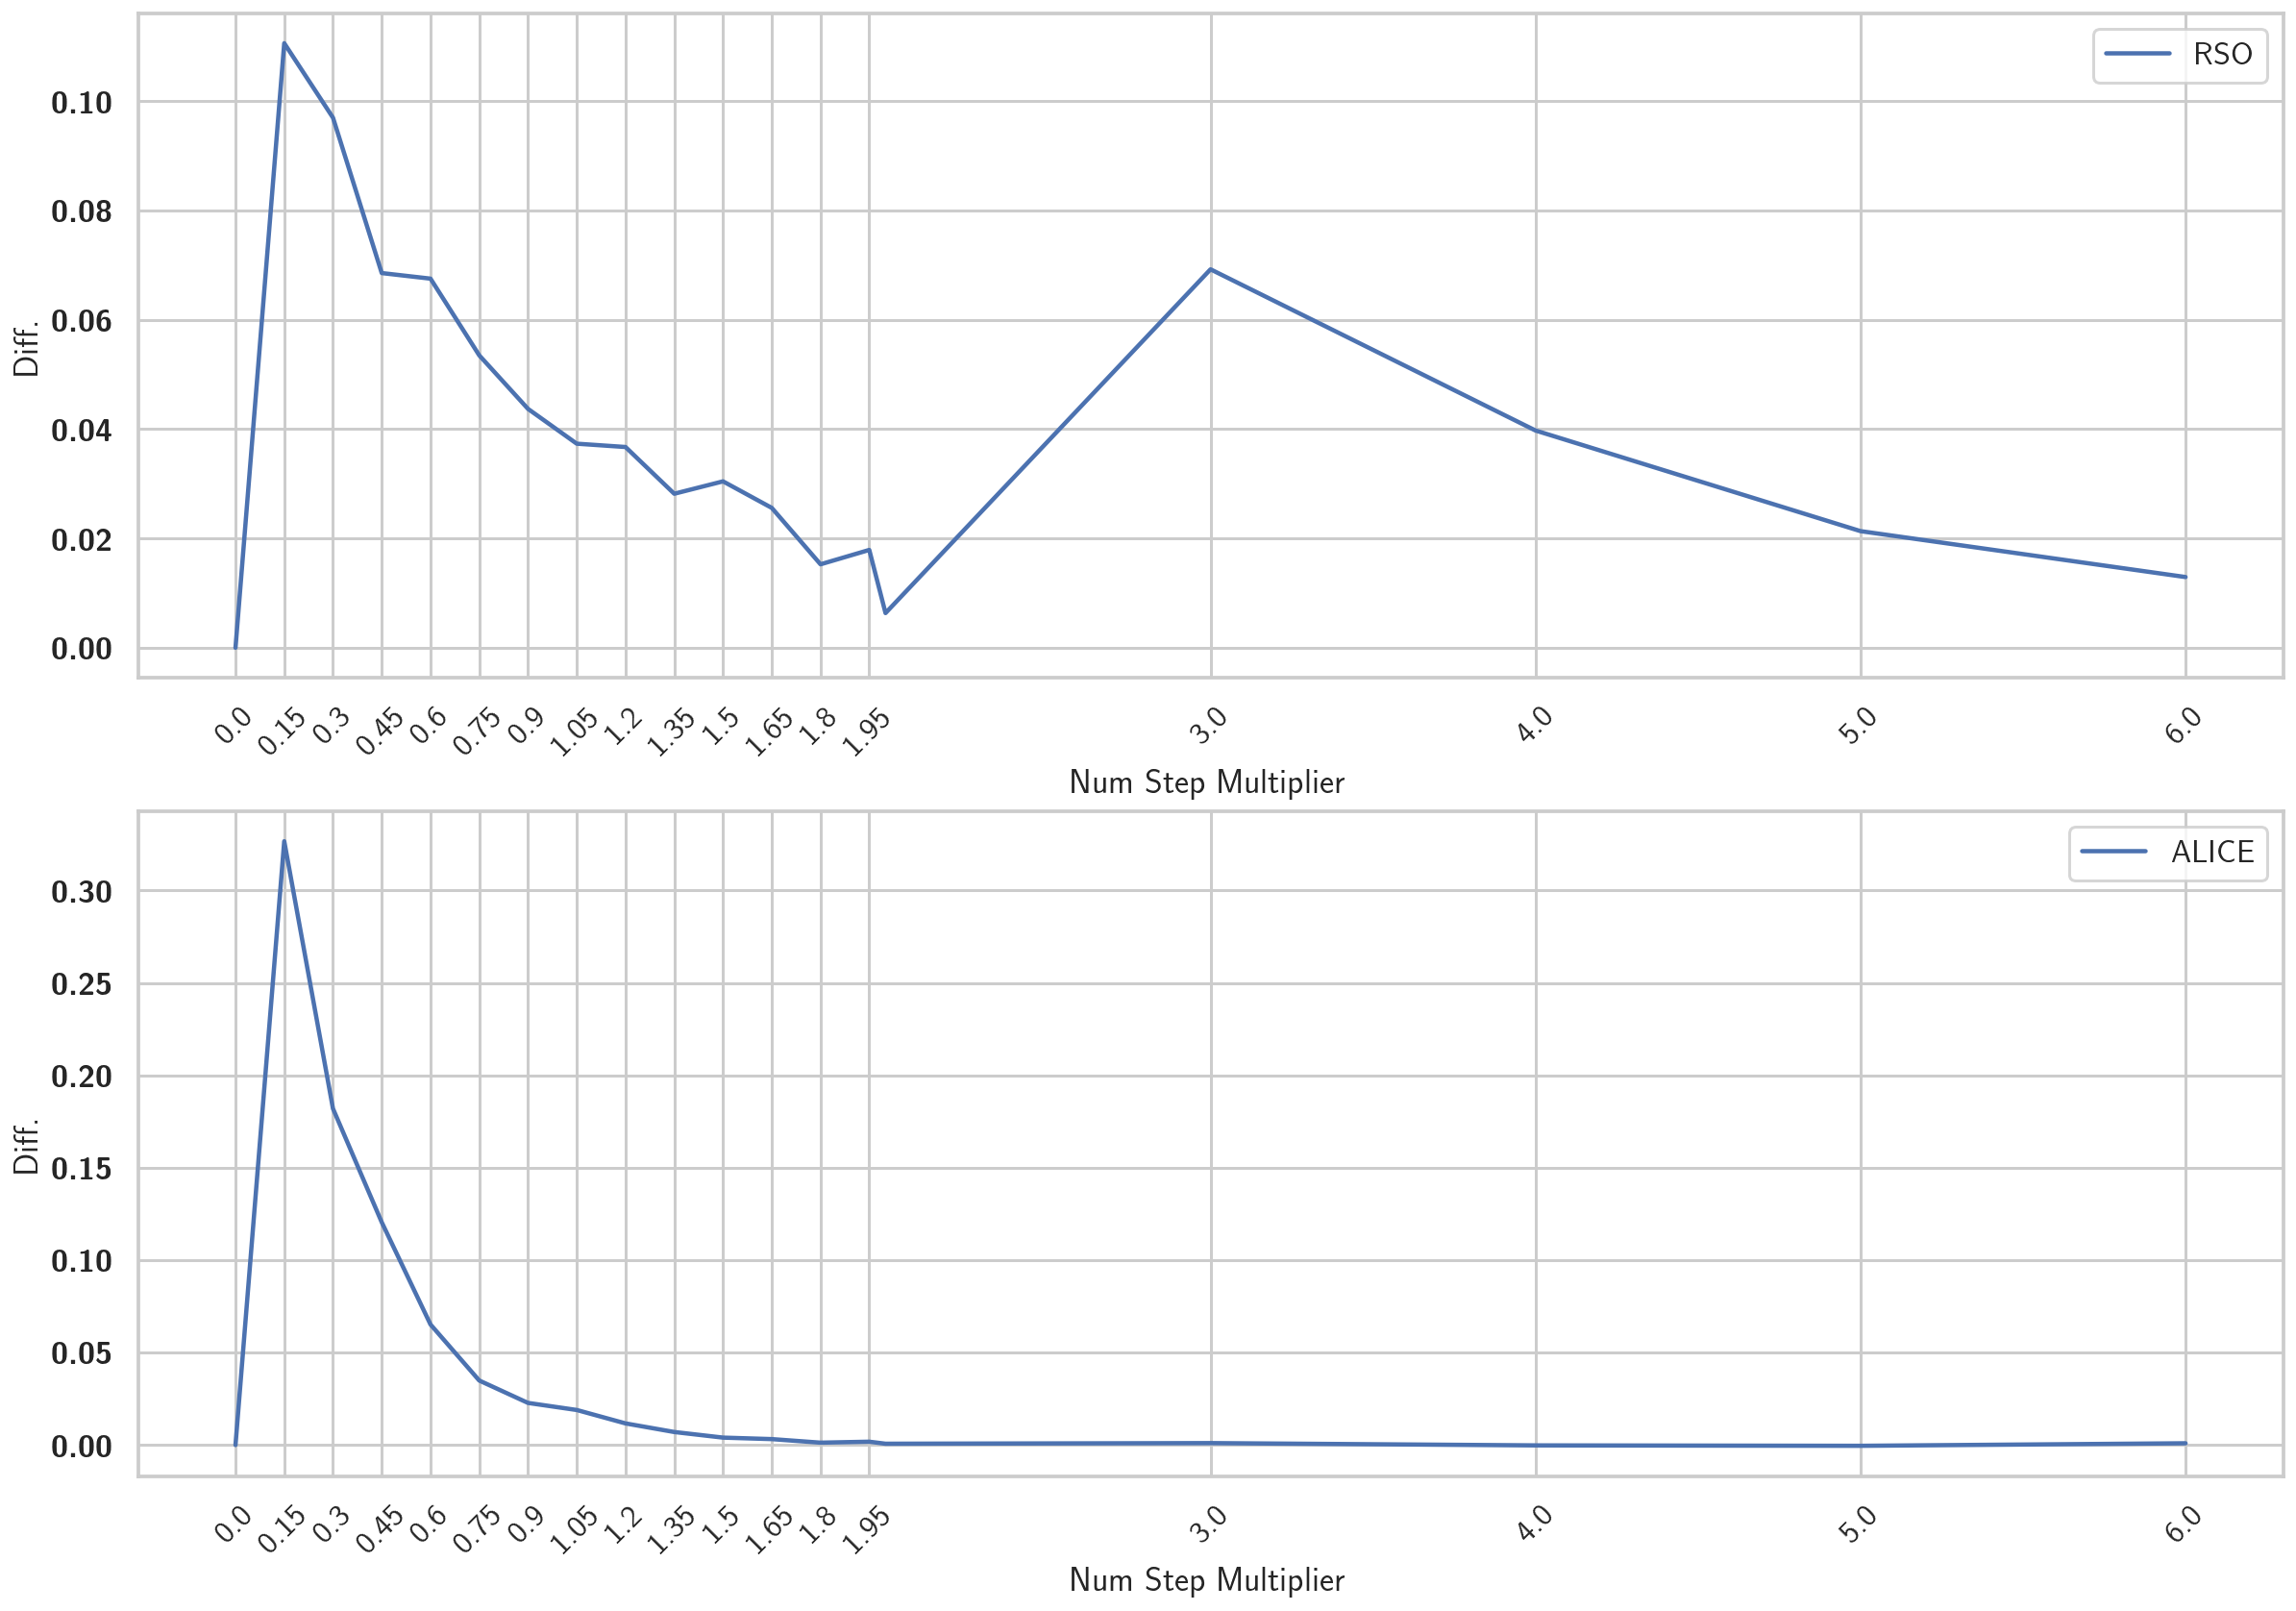

CHESS


,ARSD_RSO,RSO,ARSD_ALICE,ALICE
Num Step Multiplier,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.15,0.009628,0.009628,0.015500,0.015500
0.30,0.013978,0.004350,0.014835,-0.000665
0.45,0.014509,0.000531,0.015837,0.000964
0.60,0.014847,0.000338,0.014653,-0.001146
0.75,0.015451,0.000604,0.015622,0.000970
0.90,0.016171,0.000439,0.015626,0.000004
1.05,0.015952,0.000062,0.015495,-0.000131
1.20,0.015946,-0.000007,0.015871,0.000270


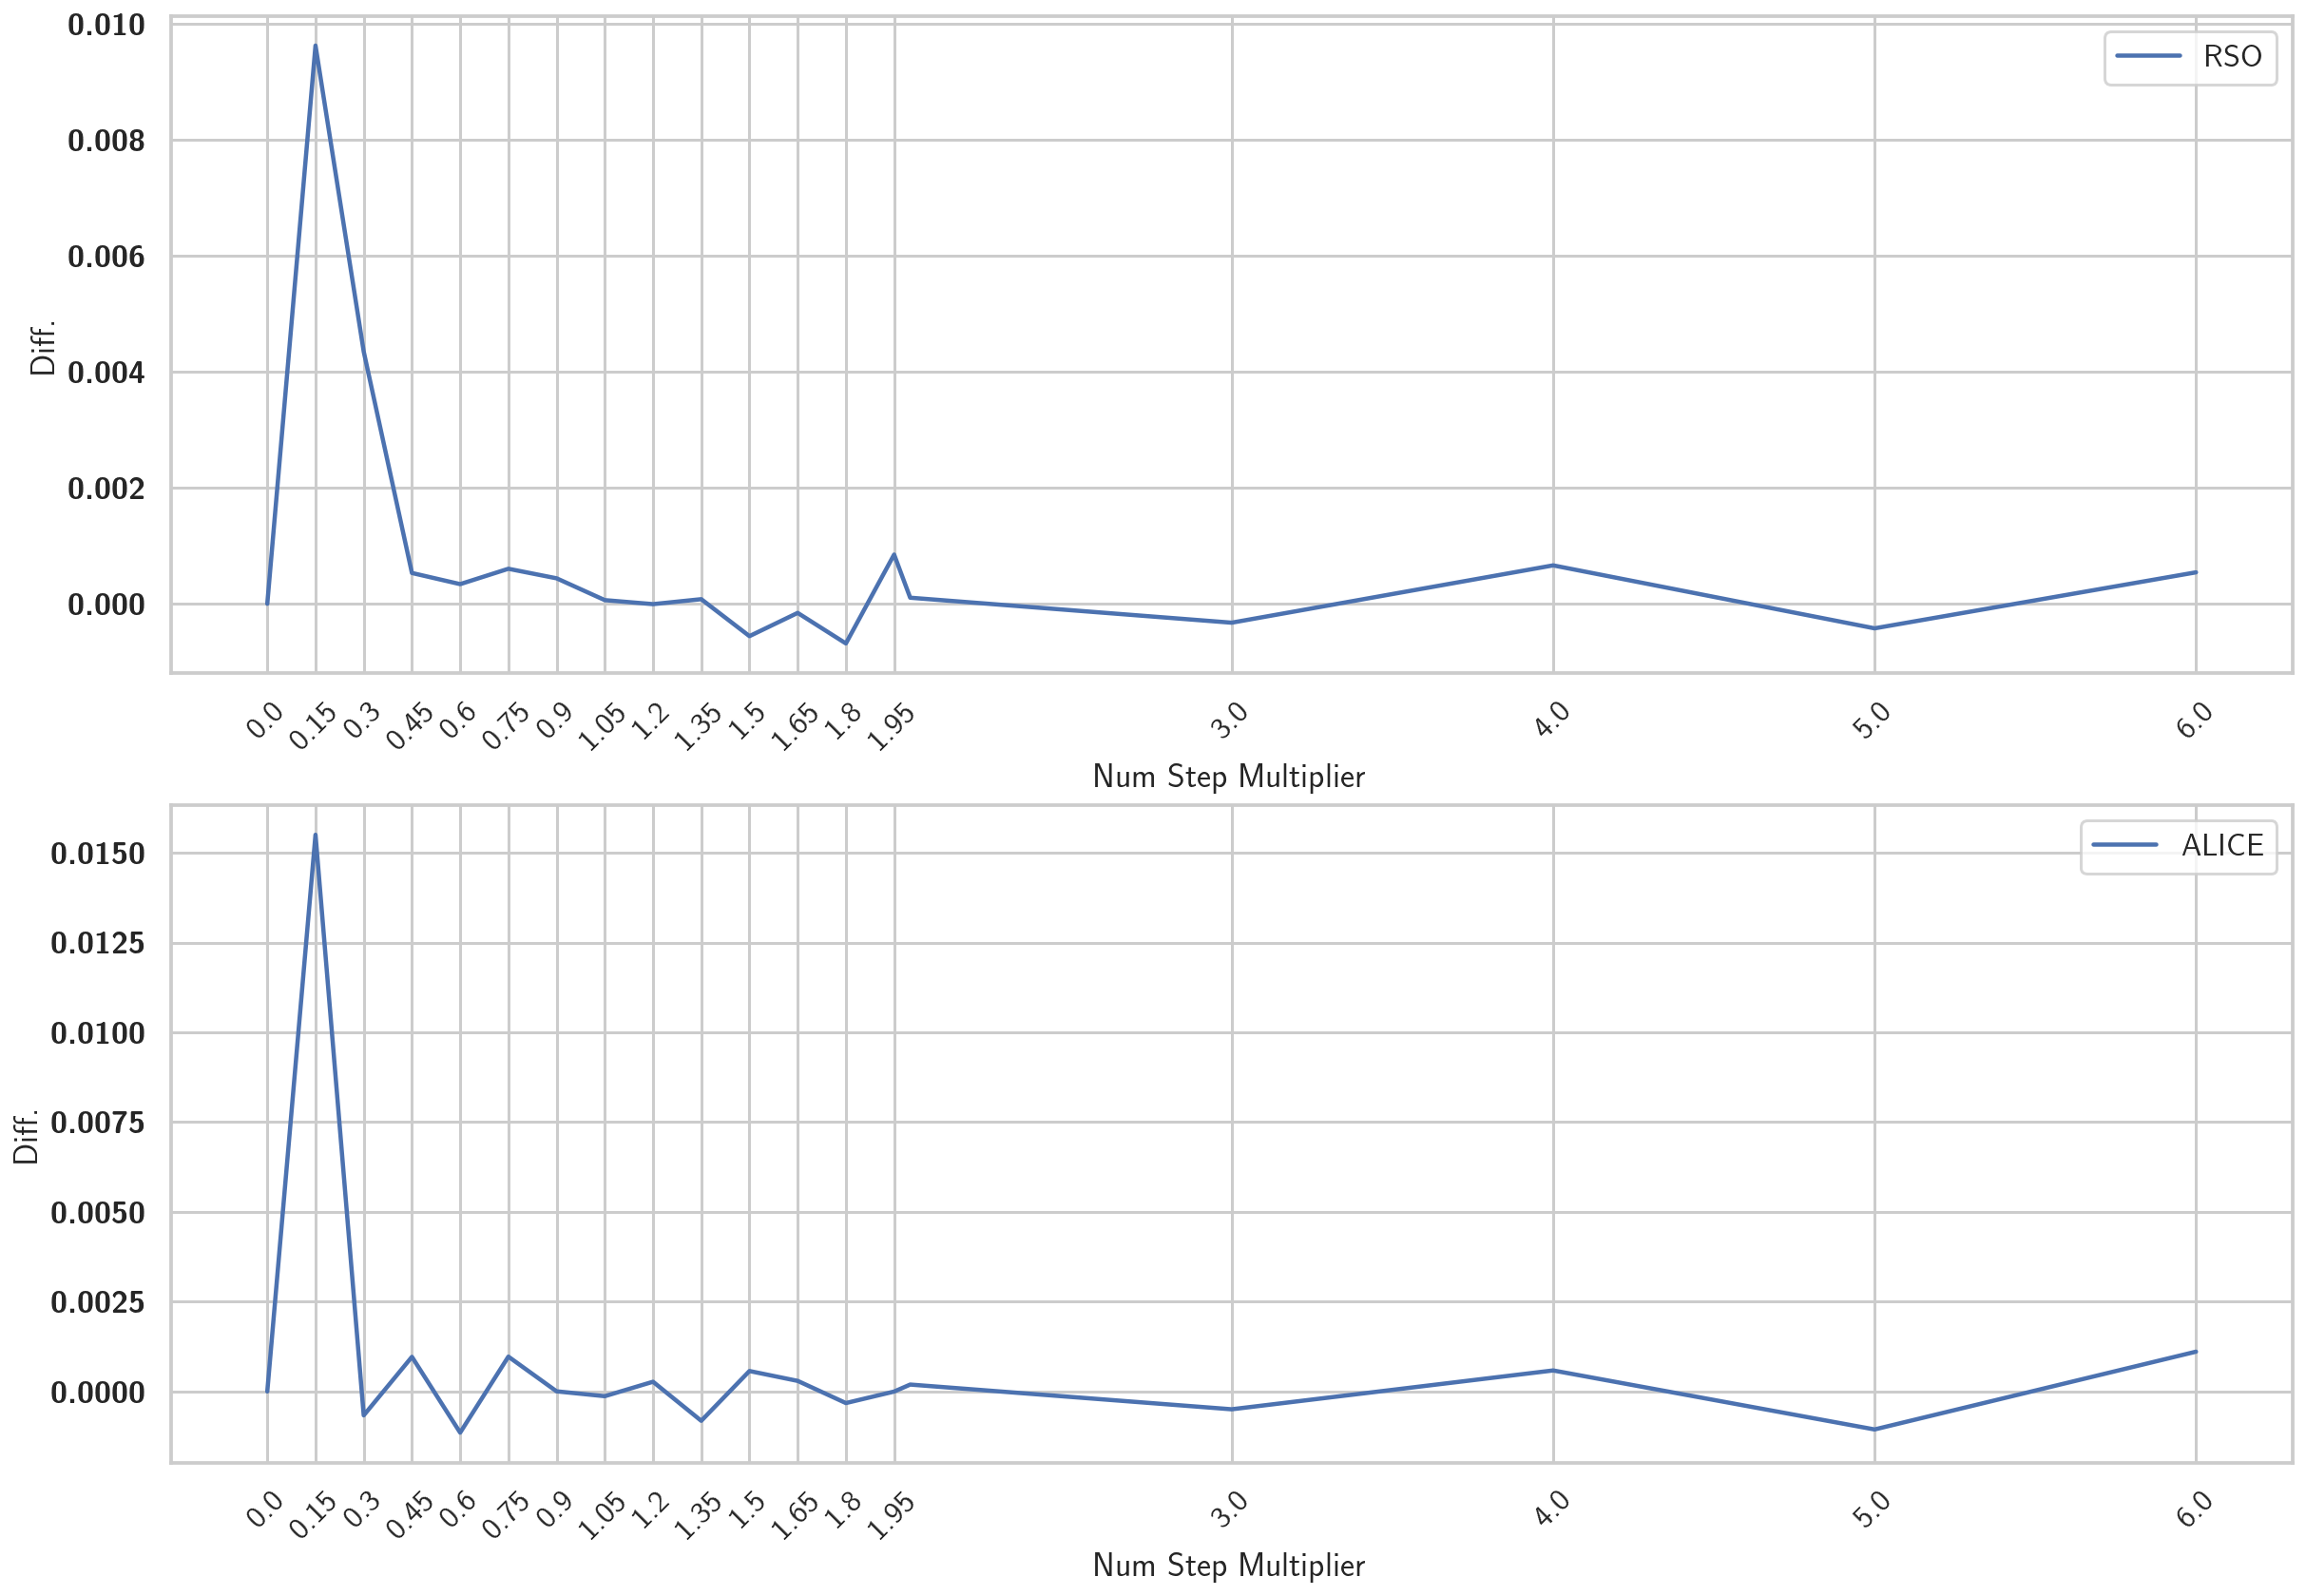

FOODMART


,ARSD_RSO,RSO,ARSD_ALICE,ALICE
Num Step Multiplier,,,,
0.00,0.000000,0.000000e+00,0.000000,0.000000
0.15,0.256063,2.560631e-01,0.559140,0.559140
0.30,0.407444,1.513814e-01,0.613884,0.054745
0.45,0.495860,8.841535e-02,0.621576,0.007692
0.60,0.540381,4.452162e-02,0.621635,0.000059
0.75,0.570246,2.986422e-02,0.621184,-0.000451
0.90,0.588298,1.805196e-02,0.619575,-0.001609
1.05,0.600502,1.220469e-02,0.621968,0.002394
1.20,0.608547,8.044894e-03,0.621478,-0.000491


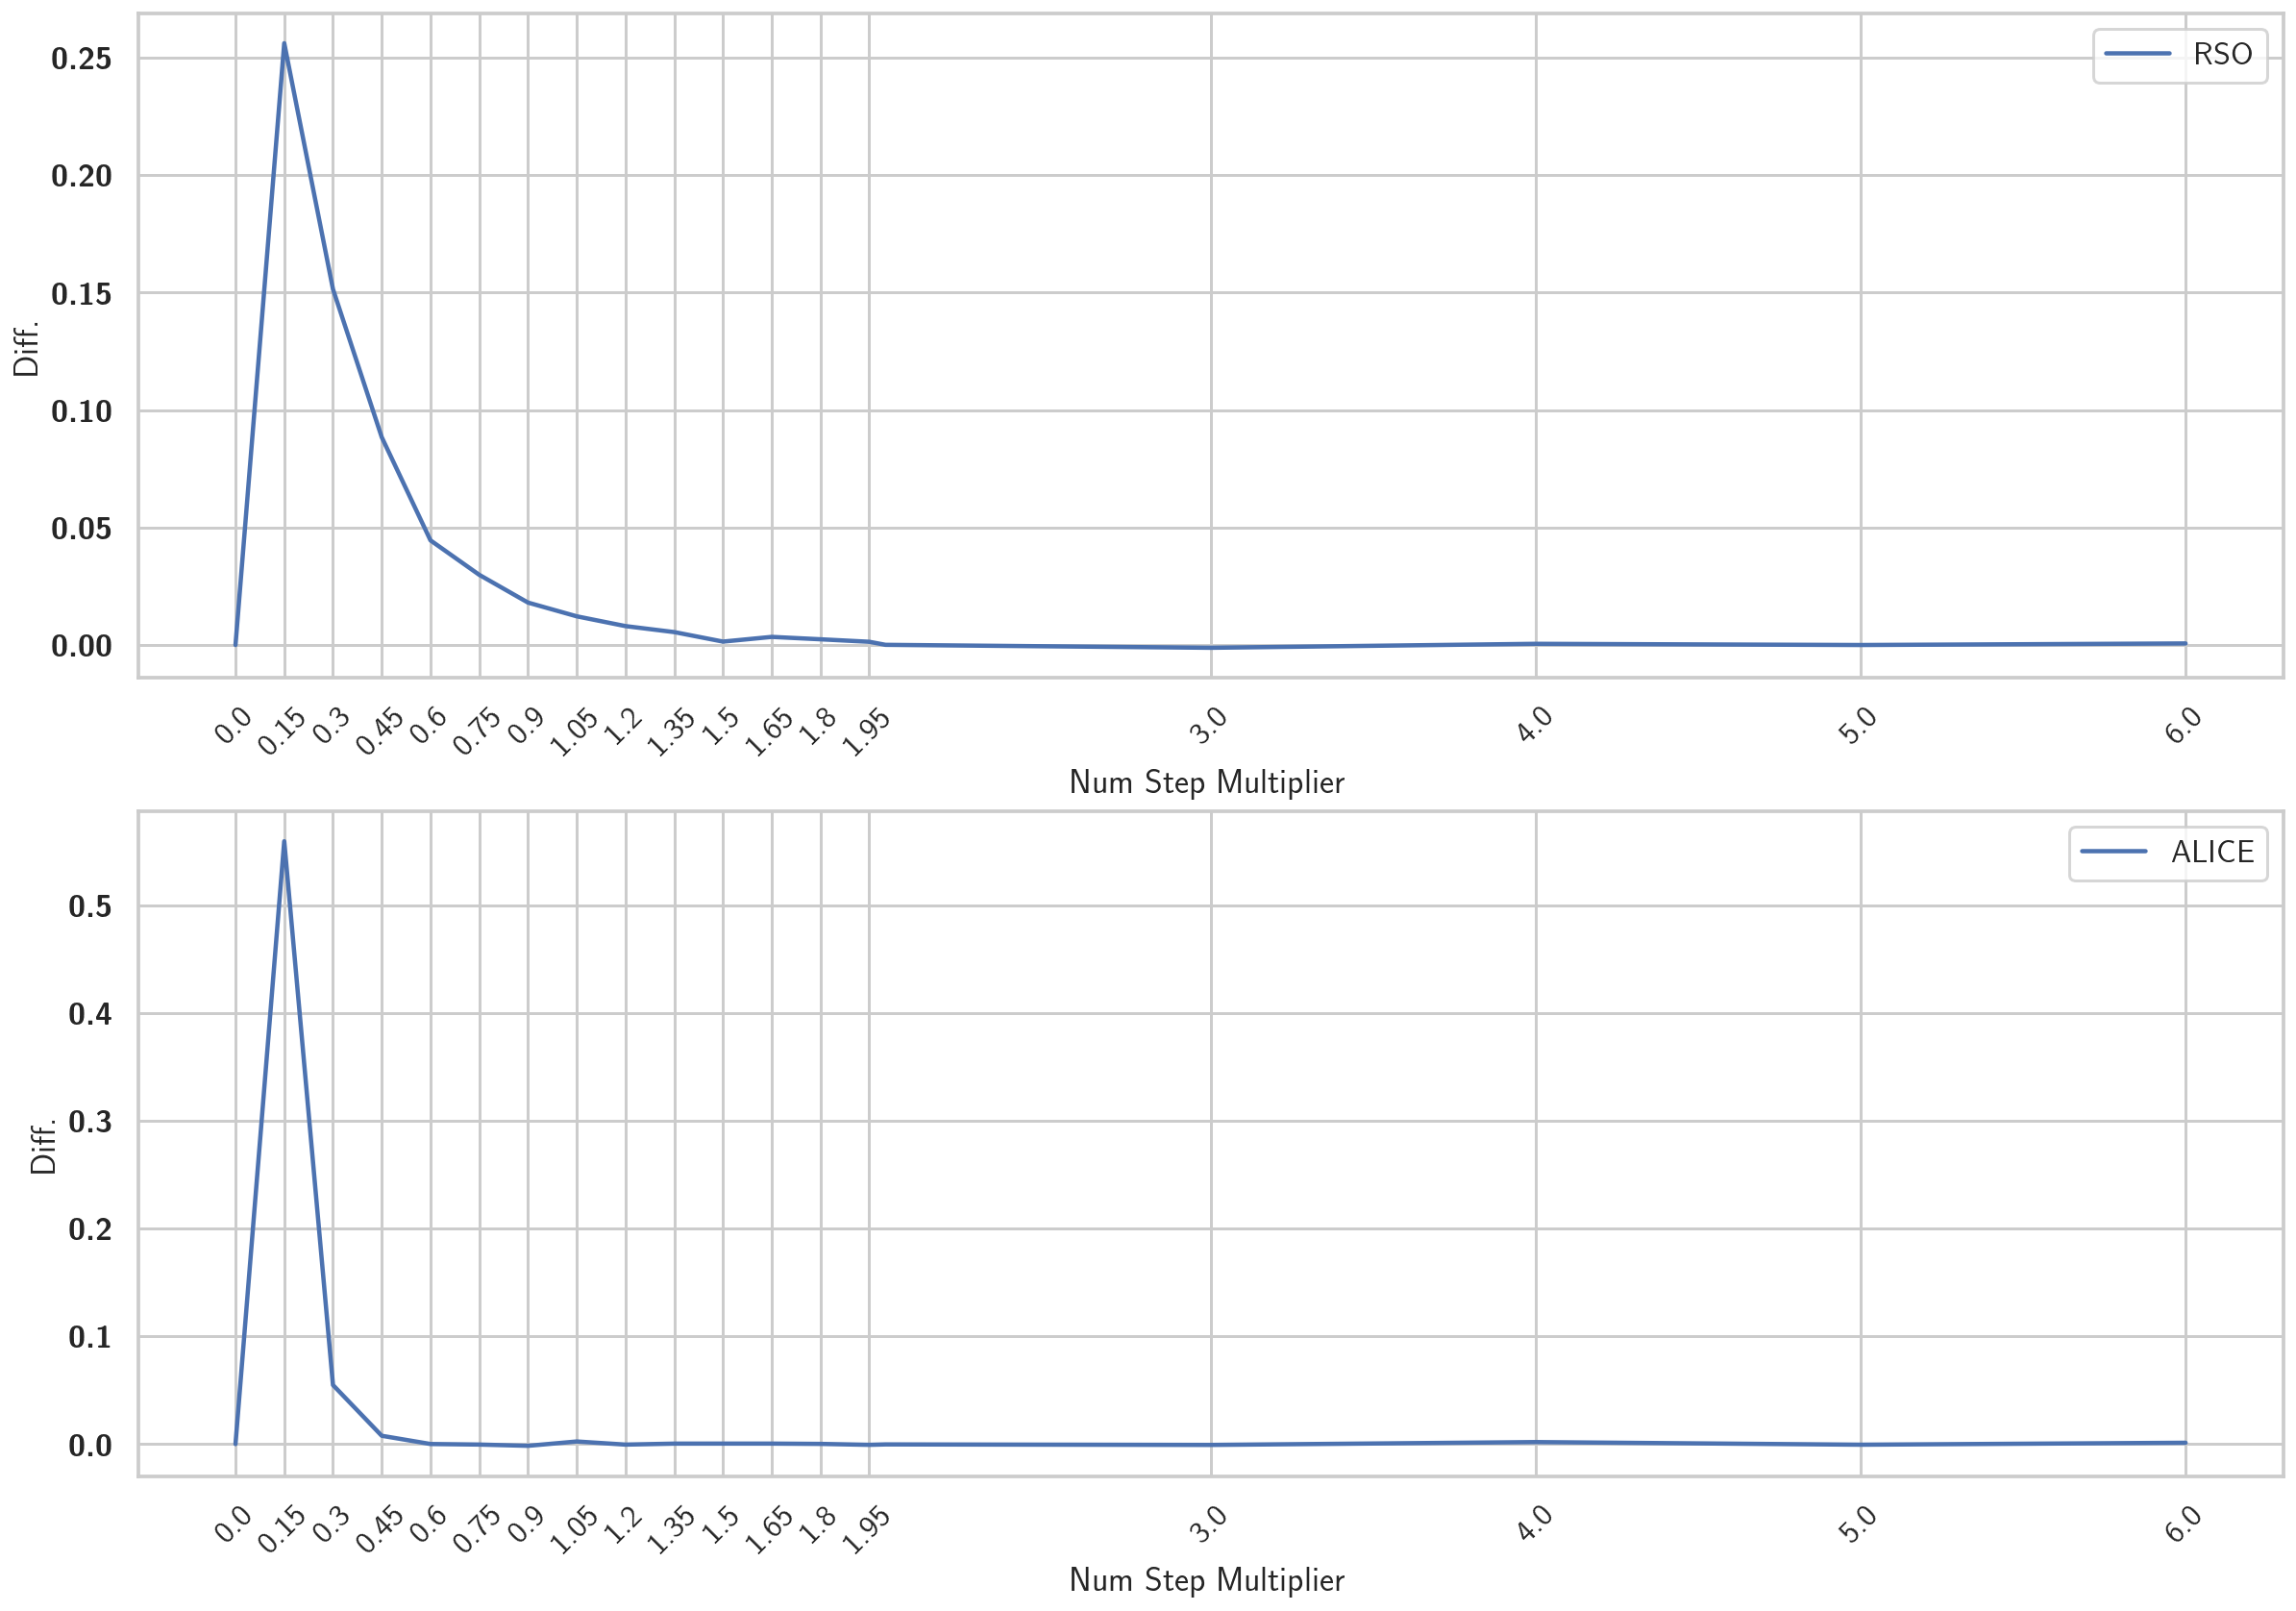

MUSHROOMS


,ARSD_RSO,RSO,ARSD_ALICE,ALICE
Num Step Multiplier,,,,
0.00,0.000000,0.000000,0.000000,0.000000
0.15,0.136046,0.136046,0.267148,0.267148
0.30,0.216598,0.080552,0.315486,0.048338
0.45,0.261686,0.045088,0.324117,0.008631
0.60,0.290078,0.028392,0.326576,-0.002164
0.75,0.304323,0.014245,0.325487,0.001089
0.90,0.314695,0.010372,0.326926,-0.001439
1.05,0.318523,0.003828,0.327309,-0.000382
1.20,0.320153,0.001630,0.327079,0.000230


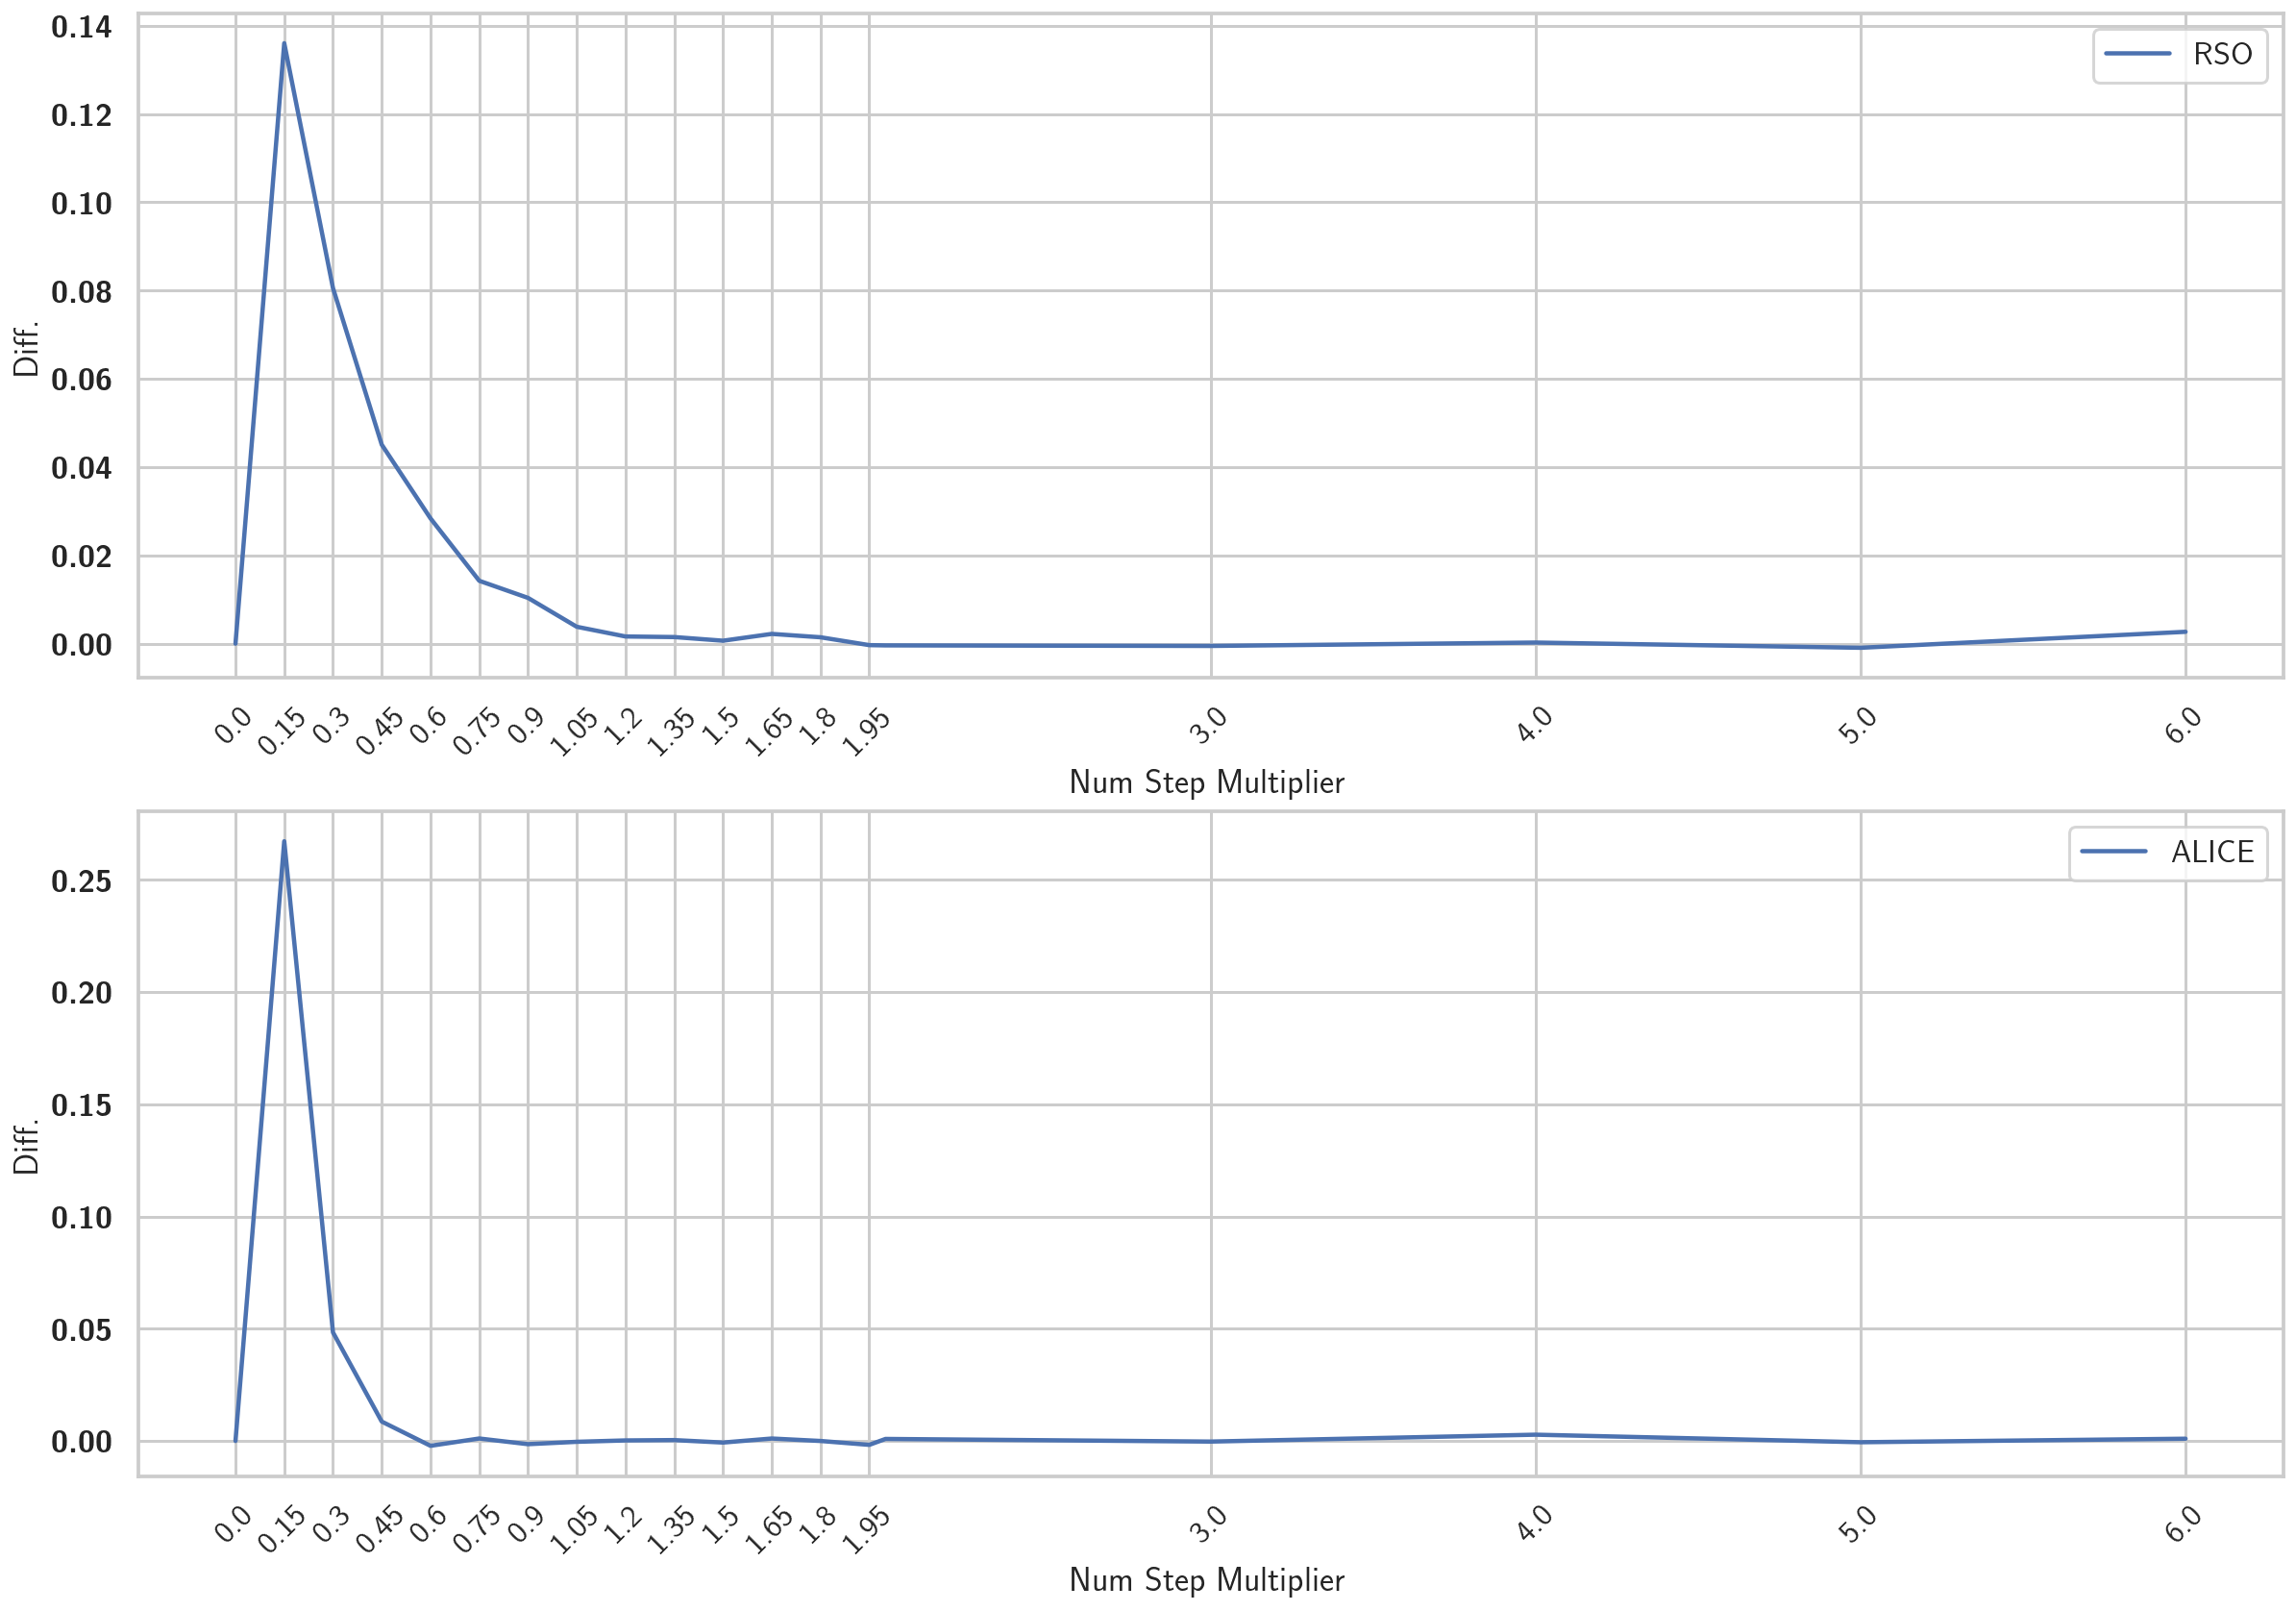

In [51]:
for db in conv_time_df['DataSet'].unique():
    print(db.upper())
    fig, ax = plt.subplots(2, 1, figsize=(20,14))
    conv_diff_df = pd.DataFrame()
    for idx, sampler in enumerate(conv_time_df['Algorithm'].unique()):
        tmp = conv_time_df[(conv_time_df['Algorithm']==sampler) &
                           (conv_time_df['DataSet']==db)].copy()
        maxARSD = tmp.loc[tmp['Num Step Multiplier']==6.0, 'Avg. Rel. Support Diff.'].values[0]
        tmp['Diff.'] = (tmp['Avg. Rel. Support Diff.'] - maxARSD).apply(abs)
        tmp['Diff.'] = (tmp['Diff.'].shift(1) - tmp['Diff.']).fillna(0)
        
        tmp2 = tmp[['Num Step Multiplier', 'Avg. Rel. Support Diff.', 'Diff.']].copy()
        tmp2.rename(columns={'Diff.':sampler,
                             'Avg. Rel. Support Diff.':f'ARSD_{sampler}'}, inplace=True)
        if conv_diff_df.empty:
            conv_diff_df = tmp2
        else:
            conv_diff_df = conv_diff_df.merge(tmp2)
        
        sns.lineplot(data=tmp, x='Num Step Multiplier', y='Diff.', ax=ax[idx], hue='Algorithm')
        ax[idx].legend()
        ticks = list(tmp['Num Step Multiplier'].values)
        ticks.remove(2.0)
        labels = [str(round(x,3)) for x in tmp['Num Step Multiplier'].values]
        labels.remove('2.0')
        ax[idx].set_xticks(ticks)
        ax[idx].set_xticklabels(labels, rotation=45, ha='center')
        ax[idx].grid(which='both', axis='x')
    display(conv_diff_df.set_index('Num Step Multiplier'))
    plt.show()

In [52]:
# ALICE = 0.6 (105.191), RSO = 1.2 (2.943)
conv_time_df[(conv_time_df['DataSet']=='mushrooms')]

,Num Step Multiplier,Algorithm,Avg. Rel. Support Diff.,Setup,Mean,Min,Max,Total,DataSet,Sum Transaction Lengths,Time,Time (s)
152,0.00,RSO,0.000000,957,0,0,0,957,mushrooms,193568,1914,1.914
153,0.15,RSO,0.136046,737,0,0,5,3960,mushrooms,193568,4697,4.697
154,0.30,RSO,0.216598,169,0,0,44,2808,mushrooms,193568,2977,2.977
155,0.45,RSO,0.261686,158,0,0,1,2727,mushrooms,193568,2885,2.885
156,0.60,RSO,0.290078,154,0,0,1,2677,mushrooms,193568,2831,2.831
157,0.75,RSO,0.304323,158,0,0,1,2666,mushrooms,193568,2824,2.824
158,0.90,RSO,0.314695,156,0,0,120,2821,mushrooms,193568,2977,2.977
159,1.05,RSO,0.318523,157,0,0,1,2665,mushrooms,193568,2822,2.822
160,1.20,RSO,0.320153,159,0,0,121,2784,mushrooms,193568,2943,2.943
161,1.35,RSO,0.321649,155,0,0,26,2645,mushrooms,193568,2800,2.800


In [53]:
# ALICE = 0.45 (0.134), RSO = 1.5 (0.069)
conv_time_df[(conv_time_df['DataSet']=='foodmart')]

,Num Step Multiplier,Algorithm,Avg. Rel. Support Diff.,Setup,Mean,Min,Max,Total,DataSet,Sum Transaction Lengths,Time,Time (s)
114,0.00,RSO,0.000000,54,0,0,0,54,foodmart,18319,108,0.108
115,0.15,RSO,0.256063,33,0,0,5,93,foodmart,18319,126,0.126
116,0.30,RSO,0.407444,19,0,0,1,50,foodmart,18319,69,0.069
117,0.45,RSO,0.495860,21,0,0,1,50,foodmart,18319,71,0.071
118,0.60,RSO,0.540381,17,0,0,1,44,foodmart,18319,61,0.061
119,0.75,RSO,0.570246,17,0,0,1,43,foodmart,18319,60,0.060
120,0.90,RSO,0.588298,16,0,0,1,42,foodmart,18319,58,0.058
121,1.05,RSO,0.600502,16,0,0,1,42,foodmart,18319,58,0.058
122,1.20,RSO,0.608547,16,0,0,1,43,foodmart,18319,59,0.059
123,1.35,RSO,0.614041,17,0,0,1,44,foodmart,18319,61,0.061


In [89]:
# ALICE = 1.8 (15.8), RSO = 6 (10.05)
conv_time_df[(conv_time_df['DataSet']=='BMS2')]

,Num Step Multiplier,Algorithm,Avg. Rel. Support Diff.,Setup,Mean,Min,Max,Total,DataSet,Sum Transaction Lengths,Time,Time (s)
38,0.00,RSO,0.000000,624,0,0,0,624,BMS2,358278,1248,1.248
39,0.15,RSO,0.110616,438,0,0,4,1811,BMS2,358278,2249,2.249
40,0.30,RSO,0.207596,442,0,0,1,1761,BMS2,358278,2203,2.203
41,0.45,RSO,0.276155,444,0,0,1,1769,BMS2,358278,2213,2.213
42,0.60,RSO,0.343695,452,0,0,1,1772,BMS2,358278,2224,2.224
43,0.75,RSO,0.397200,446,0,0,1,1793,BMS2,358278,2239,2.239
44,0.90,RSO,0.440910,510,0,0,1,1773,BMS2,358278,2283,2.283
45,1.05,RSO,0.478253,456,0,0,70,1806,BMS2,358278,2262,2.262
46,1.20,RSO,0.514986,458,0,0,1,1804,BMS2,358278,2262,2.262
47,1.35,RSO,0.543170,447,0,0,1,1789,BMS2,358278,2236,2.236


In [90]:
conv_time_df

,Num Step Multiplier,Algorithm,Avg. Rel. Support Diff.,Setup,Mean,Min,Max,Total,DataSet,Sum Transaction Lengths,Time,Time (s)
0,0.00,RSO,0.000000,340,0,0,0,340,BMS1,149639,680,0.680
1,0.15,RSO,0.053912,268,0,0,5,1004,BMS1,149639,1272,1.272
2,0.30,RSO,0.092866,240,0,0,1,866,BMS1,149639,1106,1.106
3,0.45,RSO,0.124772,265,0,0,1,942,BMS1,149639,1207,1.207
4,0.60,RSO,0.153301,261,0,0,1,893,BMS1,149639,1154,1.154
...,...,...,...,...,...,...,...,...,...,...,...,...
185,2.00,ALICE,0.327189,171,0,0,167,36476,mushrooms,193568,36647,36.647
186,3.00,ALICE,0.327474,163,0,0,132,709443,mushrooms,193568,709606,709.606
187,4.00,ALICE,0.324686,156,0,0,134,709165,mushrooms,193568,709321,709.321
188,5.00,ALICE,0.325259,158,0,0,139,707652,mushrooms,193568,707810,707.810


## Scalability

In [39]:
result_dir = '../output/scalability/'
# config
dbs = ['synthetic-5', 'synthetic-10', 
       'synthetic-15', 'synthetic-20']
real_dbs = ['chess', 'foodmart', 'mushrooms', 'BMS1', 'BMS2']

In [40]:
results_df = pd.DataFrame()
for db in dbs:
    file_name = f'{db}-25-0.1-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_scalability_df(file, file_name)
    tmp_df['DataSet'] = db
    results_df = results_df.append(tmp_df, ignore_index=True)
for db in real_dbs:
    file_name = f'{db}-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_scalability_df(file, file_name)
    tmp_df['DataSet'] = db
    results_df = results_df.append(tmp_df, ignore_index=True)

In [41]:
results_df['Algorithm'] = results_df['Algorithm'].apply(lambda x: sampler_names[x])

### Synthetic Datasets

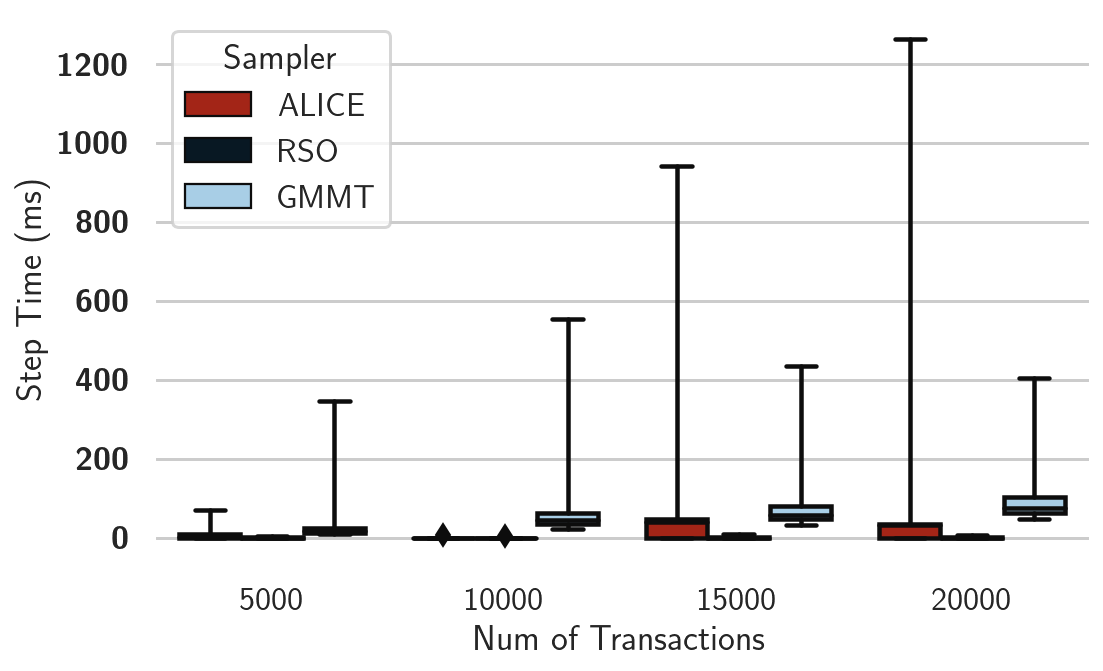

In [44]:
fig, ax = plt.subplots(figsize=(8,5))

data = results_df[results_df['DataSet'].isin(dbs)]
sns.boxplot(data=data, x='Number of transactions', whis=100,
            palette=palette, fliersize=8, y='Step time (ms)', 
            hue='Algorithm', hue_order=['ALICE', 'RSO', 'GMMT'], ax=ax)
# ax.set_ylim(top=100, bottom=0)
ax.set_xlabel('Num of Transactions')
ax.set_ylabel('Step Time (ms)')
ax.legend(title='Sampler')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_dir+'scalability.pdf')

### Real Datasets

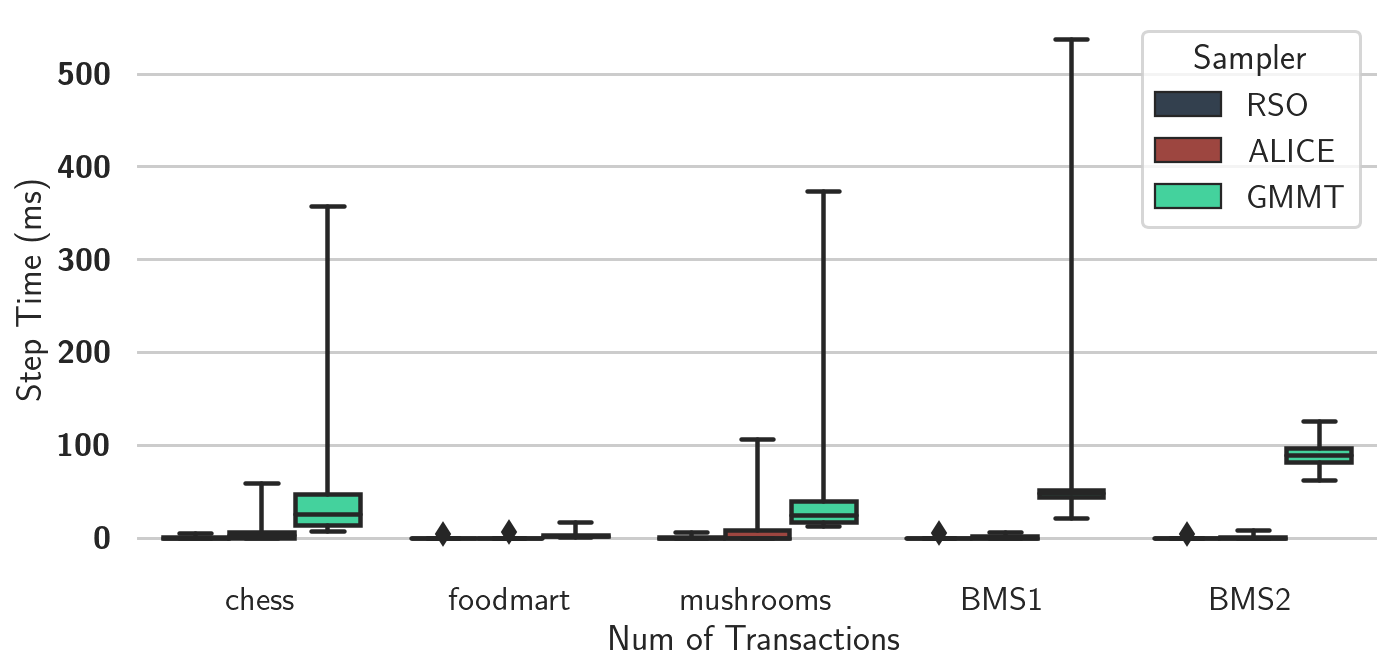

In [57]:
fig, ax = plt.subplots(figsize=(10,5))

data = results_df[results_df['DataSet'].isin(real_dbs)]
sns.set_theme(style='whitegrid', context='talk')
sns.boxplot(data=data, x='DataSet', whis=100,
            palette=palette, fliersize=8, y='Step time (ms)', 
            hue='Algorithm', ax=ax)
# ax.set_ylim(top=100, bottom=0)
ax.set_xlabel('Num of Transactions')
ax.set_ylabel('Step Time (ms)')
ax.legend(title='Sampler')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_dir+'scalability_real.pdf')

#### Step Time

In [59]:
swap_df = pd.DataFrame()
for db in real_dbs:
    file_name = f'{db}-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_step_times_df(file)
    tmp_df['DataSet'] = db
    swap_df = swap_df.append(tmp_df, ignore_index=True)

In [60]:
swap_df.columns = ['Algorithm', 'min', 'C10', 'Q1', 'med.', 'Q3', 'C90', 'max', 'Dataset']

In [61]:
swap_df['Algorithm'] = swap_df['Algorithm'].apply(lambda x: sampler_names[x])

In [62]:
sorted_df = swap_df.sort_values(by=['Dataset', 'Algorithm'])

In [63]:
print(sorted_df.to_latex(index=False, column_format='llrrrrr',
                        caption='Step time (ms): minimum, 1st quartile, median, 3rd quartile, and maximum over 10K steps.',
                        label='tbl:steptime', position='!ht'))

\begin{table}[!ht]
\centering
\caption{Step time (ms): minimum, 1st quartile, median, 3rd quartile, and maximum over 10K steps.}
\label{tbl:steptime}
\begin{tabular}{llrrrrr}
\toprule
Algorithm &  min &  C10 &  Q1 &  med. &  Q3 &  C90 &  max &   Dataset \\
\midrule
    ALICE &    0 &    0 &   0 &     0 &   1 &    2 &    6 &      BMS1 \\
     GMMT &   21 &   43 &  45 &    48 &  50 &   52 &  537 &      BMS1 \\
      RSO &    0 &    0 &   0 &     0 &   0 &    0 &    5 &      BMS1 \\
    ALICE &    0 &    0 &   0 &     0 &   1 &    1 &    8 &      BMS2 \\
     GMMT &   62 &   79 &  84 &    89 &  94 &   98 &  126 &      BMS2 \\
      RSO &    0 &    0 &   0 &     0 &   0 &    0 &    4 &      BMS2 \\
    ALICE &    0 &    0 &   0 &     3 &   4 &    7 &   59 &     chess \\
     GMMT &    7 &   12 &  16 &    25 &  38 &   56 &  357 &     chess \\
      RSO &    0 &    0 &   0 &     0 &   1 &    1 &    5 &     chess \\
    ALICE &    0 &    0 &   0 &     0 &   0 &    0 &    6 &  foodmart \\
    

## Num Frequent Itemsets

In [21]:
result_dir = '../output/numFreqItemsets'

In [22]:
db_config = {'foodmart':'18319-2176-3.0E-4-32-0',
             'chess':'118252-2176-0.8-32-0',
             'mushrooms':'193568-2176-0.3-32-0',
             'BMS1':'299278-2176-0.001-32-0',
             'BMS2':'716556-2048-0.002-32-0'
            }

In [25]:
numfreq_df = pd.DataFrame()
for db,conf in db_config.items():
    try:
        filepath = f'{result_dir}/{db}-{conf}.json'
        df = ns.get_num_freq_itemsets_stats(filepath, db.upper())
        df['DataSet'] = db
    except Exception as e:
        print(db,e)
        pass
    numfreq_df = numfreq_df.append(df, ignore_index=True)

In [26]:
numfreq_df['Algorithm'] = numfreq_df['Algorithm'].apply(lambda x: sampler_names.get(x, x))

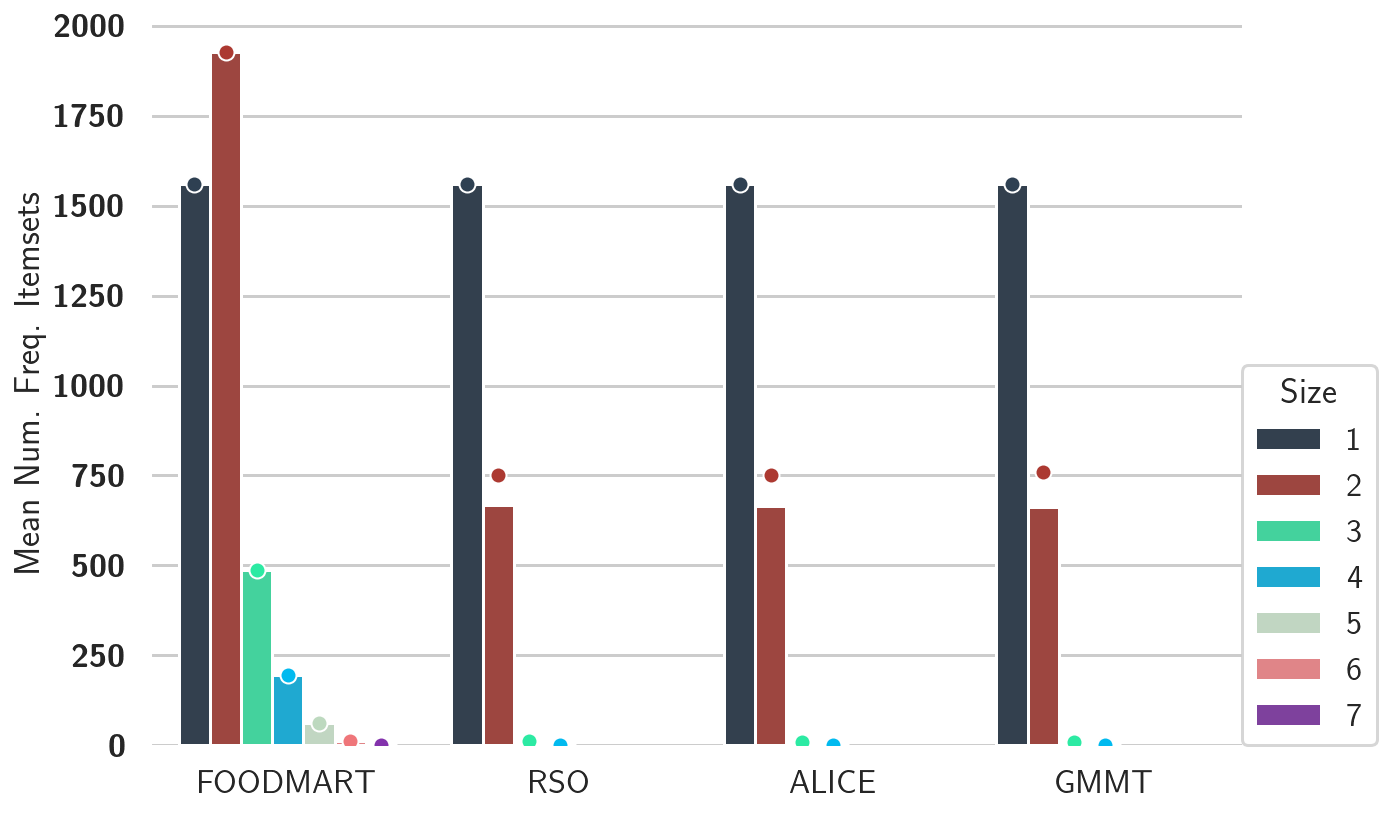

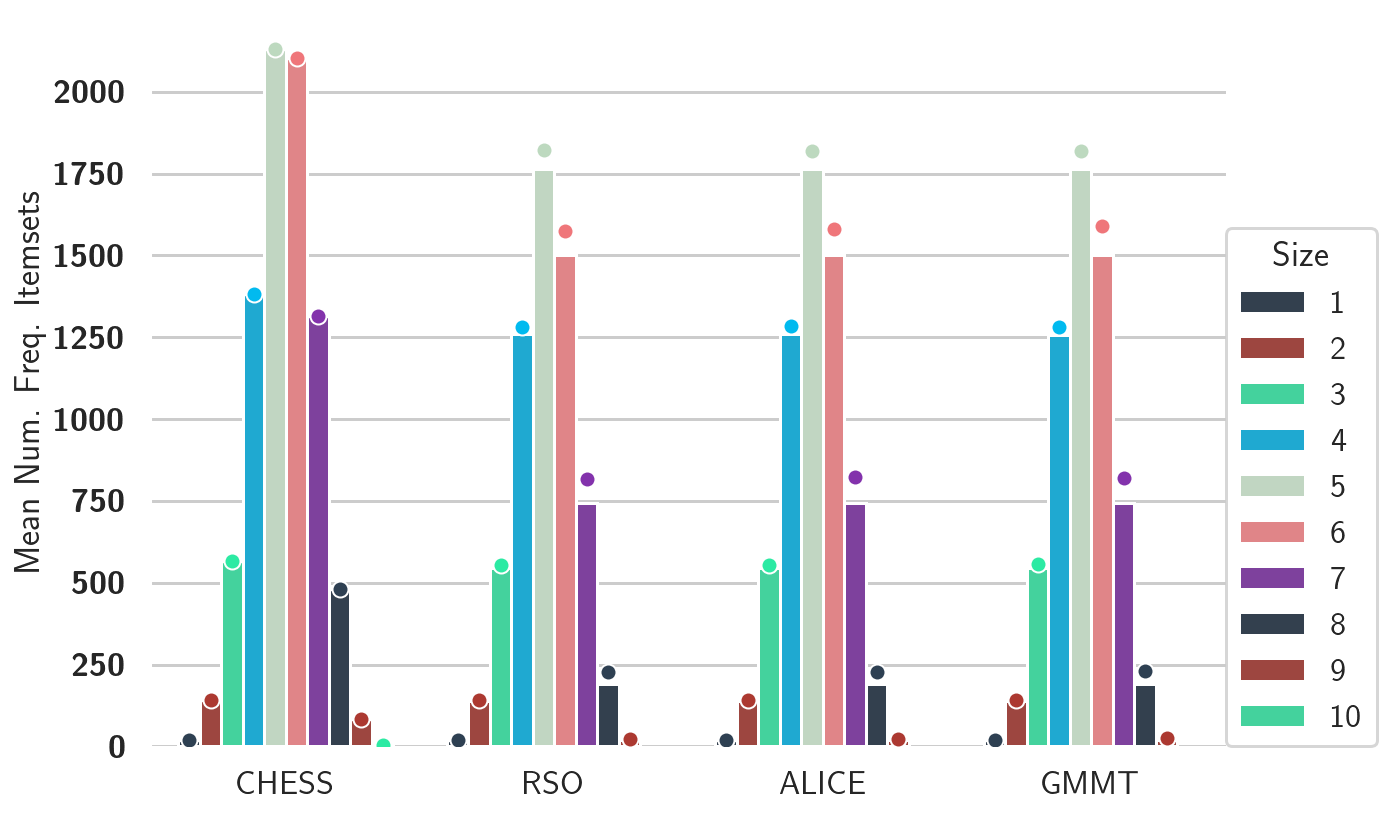

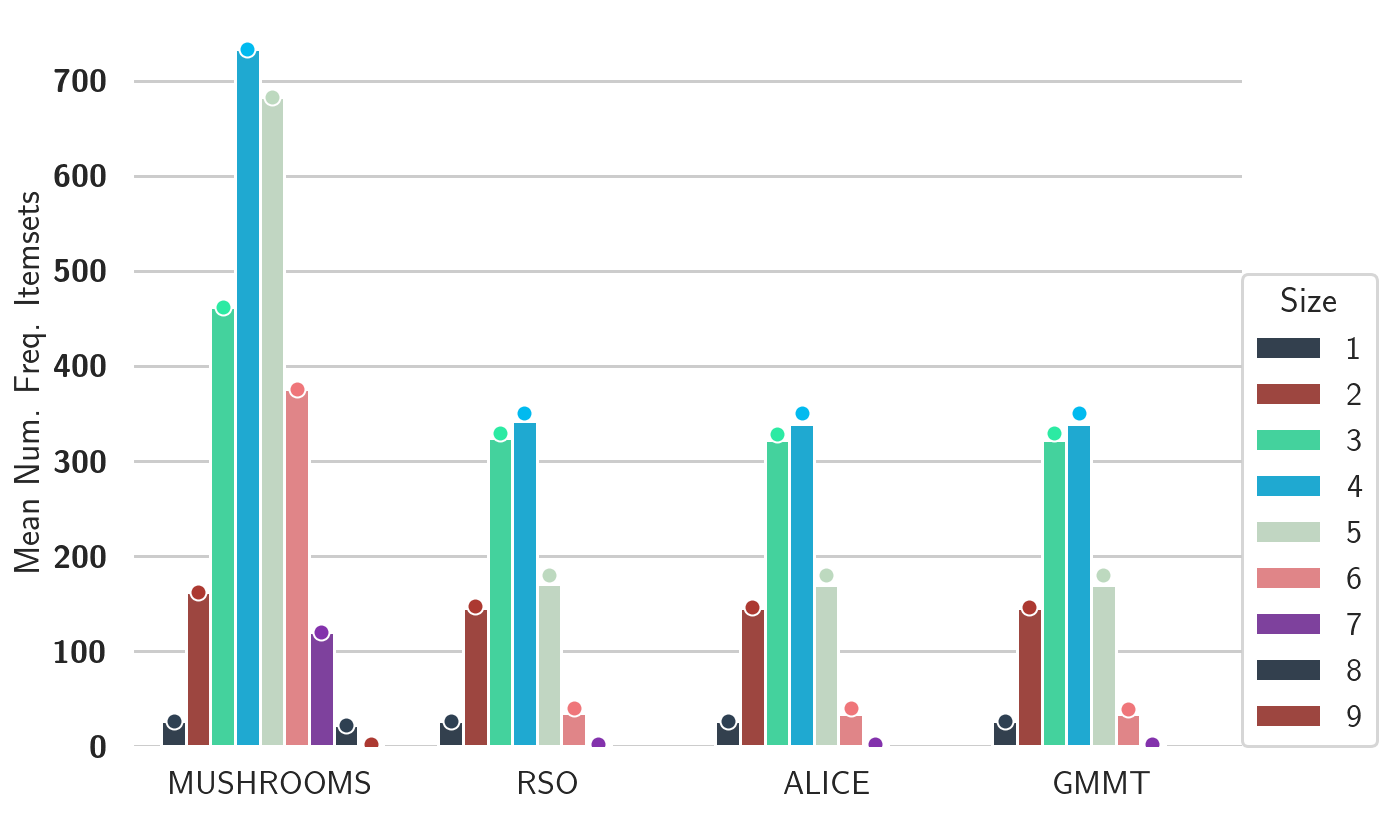

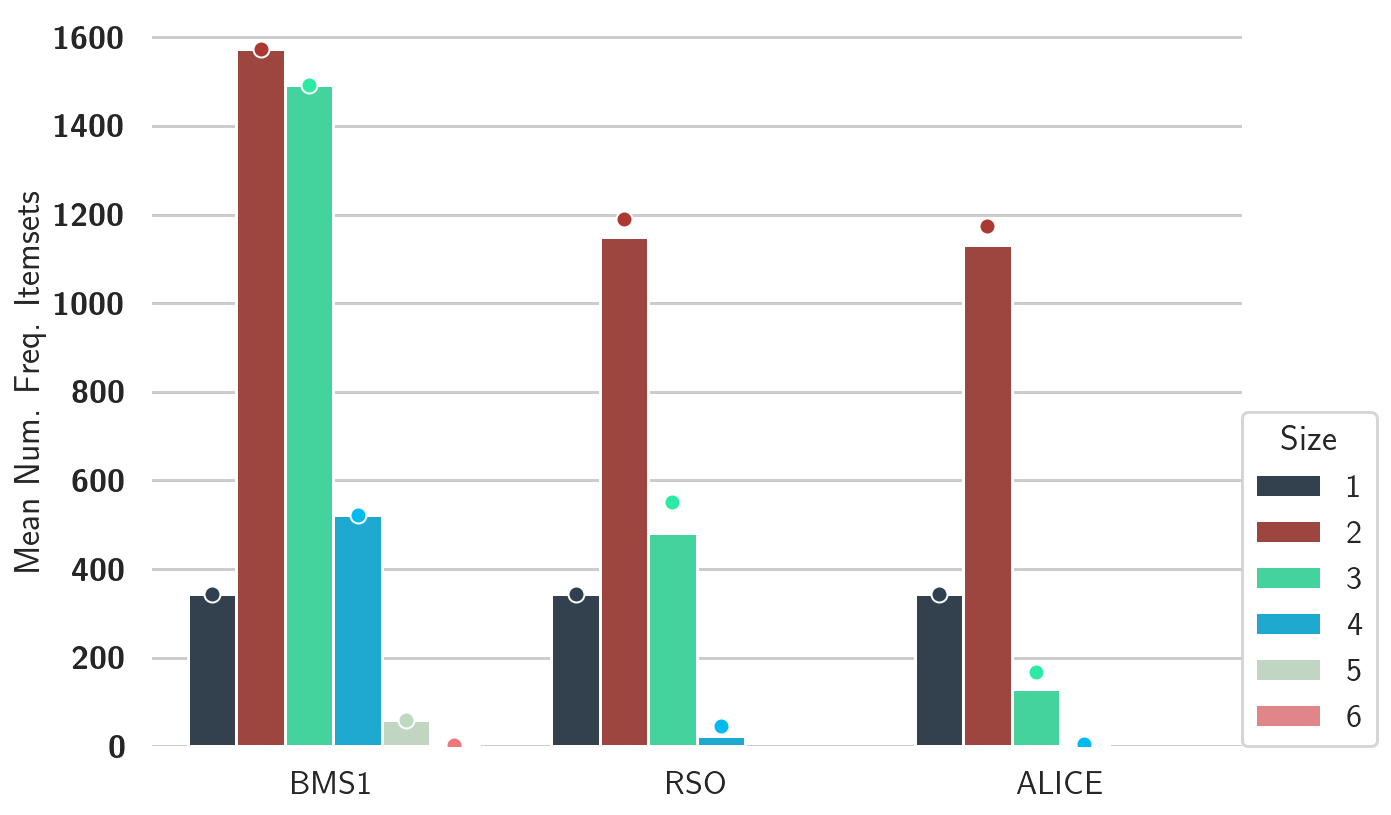

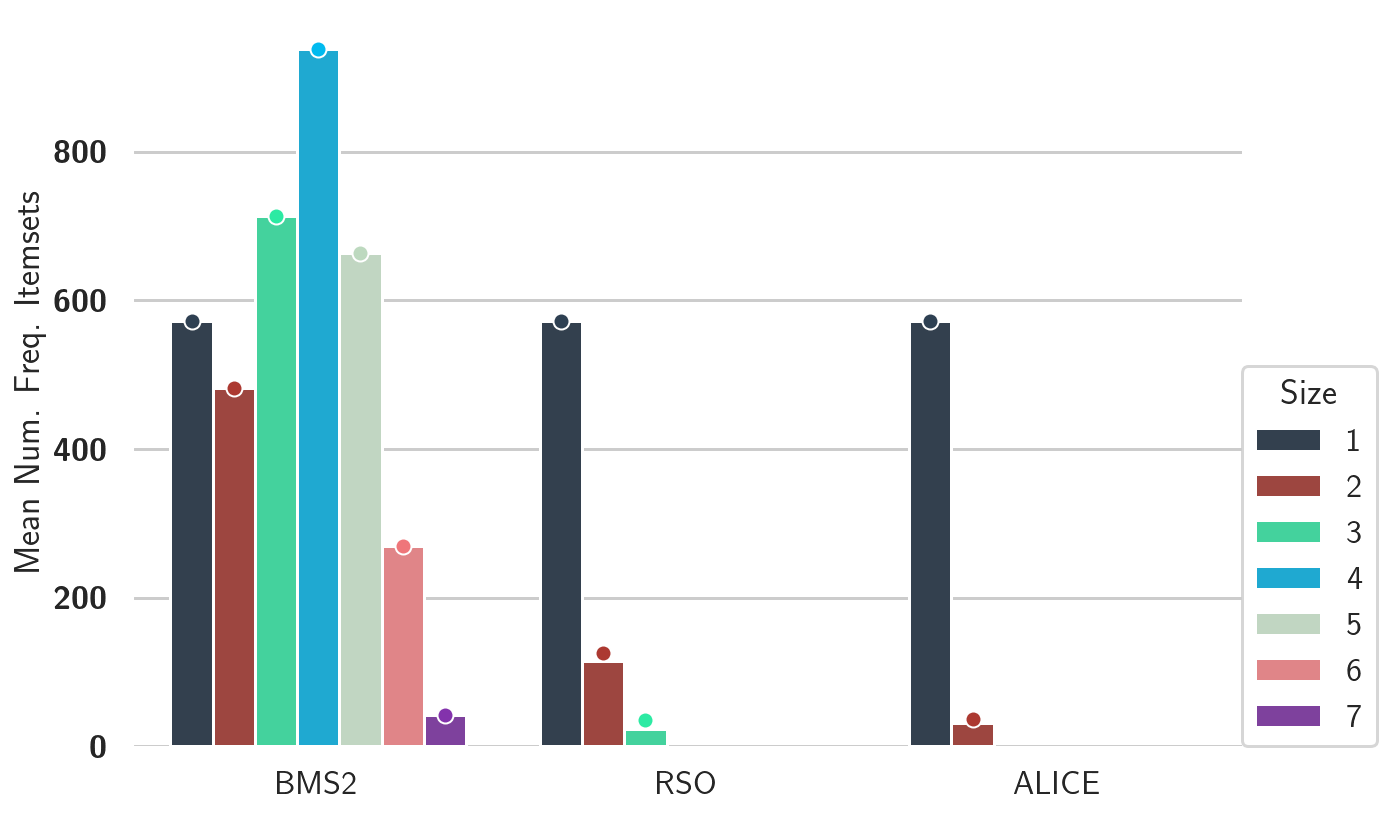

In [29]:
for db in db_config.keys():
    data = numfreq_df[numfreq_df['DataSet']==db]
    fig, ax = plt.subplots(figsize=(10,6))
    f = sns.barplot(data=data, x='Algorithm', hue='Size',
                palette=palette, y='med')
    h,l = f.get_legend_handles_labels()
    g = sns.swarmplot(data=data, x='Algorithm', hue='Size',
                  edgecolor='white', linewidth=1, label='_nolegend_',
                  dodge=True, palette=palette, y='max', size=8)
    g.legend().remove()
    ax.legend(h,l, title='Size', loc=(1,0))
    ax.set_ylabel('Mean Num. Freq. Itemsets')
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(fig_dir+f'{db}_numFreqItemsets.pdf')
    plt.show()

In [28]:
numfreq_df[(numfreq_df['Size']=='1') & 
           (numfreq_df['Algorithm']!='original')][['DataSet', 'Algorithm', 'pvalue']].dropna()

,DataSet,Algorithm,pvalue
7,foodmart,RSO,0.000459
11,foodmart,ALICE,0.000459
15,foodmart,GMMT,0.000459
29,chess,RSO,0.000459
38,chess,ALICE,0.000459
47,chess,GMMT,0.000459
65,mushrooms,RSO,0.000459
72,mushrooms,ALICE,0.000459
79,mushrooms,GMMT,0.000589
92,BMS1,RSO,0.000459


## Significant Itemset Mining

In [30]:
result_dir = '../output/significantItemsets'

In [36]:
db_config = {'foodmart':'18319-2048-128-3.0E-4-0.05-32-0',
             'chess':'118252-2048-128-0.8-0.05-32-0',
             'mushrooms':'193568-1568-128-0.3-0.05-32-0',
             'BMS1':'299278-1568-128-0.001-0.05-32-0',
             'BMS2':'716556-1568-128-0.002-0.05-32-0'}

In [37]:
results = []
for db,conf in db_config.items():
    for p in combinations(samplers, 2):
        try:
            fileA = f'{result_dir}/{db}-{p[0]}-{conf}.json'
            fileB = f'{result_dir}/{db}-{p[1]}-{conf}.json'
            num_a, num_b, jac, a_in_b, b_in_a = sig.analyze(fileA, fileB)
            results.append([db, p[0], p[1], jac, num_a, a_in_b])
            results.append([db, p[1], p[0], jac, num_b, b_in_a])
        except Exception as e:
            pass
sig_df = pd.DataFrame(results)
sig_df.columns = ['DataSet', 'Algorithm', 'Other', 'Jaccard', 'NumSignItemsets', 'isSubset']
sig_df['Algorithm'] = sig_df['Algorithm'].apply(lambda x: sampler_names[x])
sig_df['Other'] = sig_df['Other'].apply(lambda x: sampler_names[x])

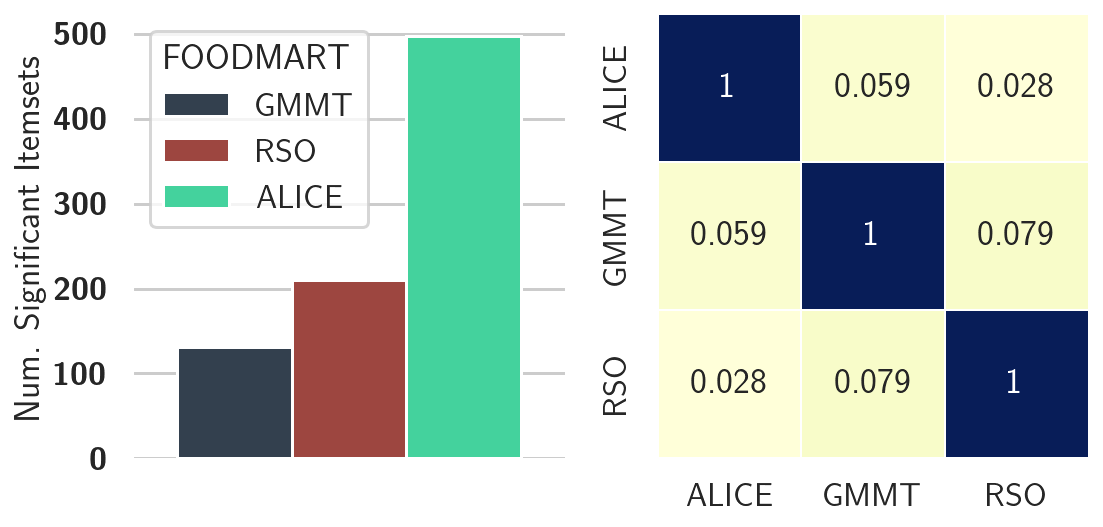

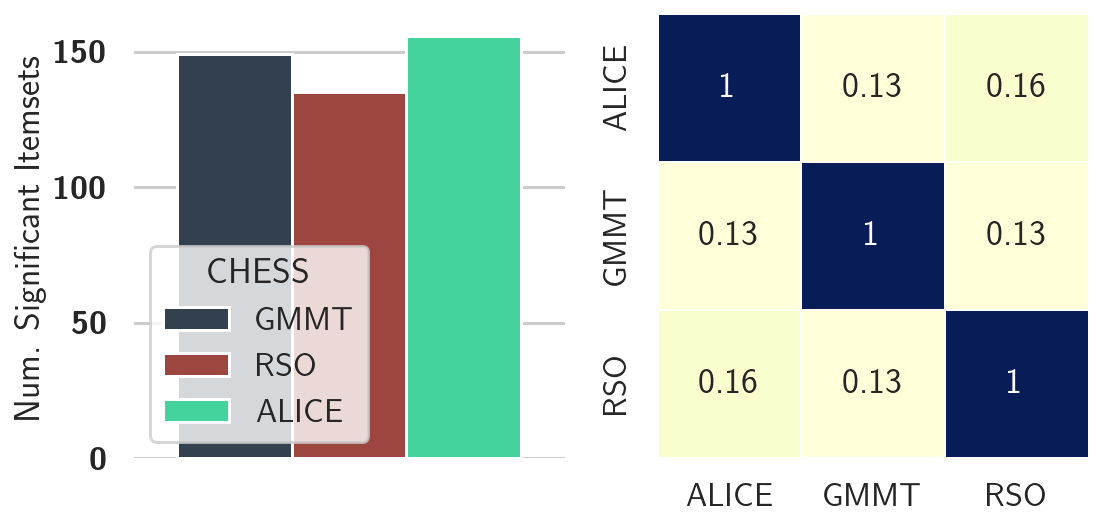

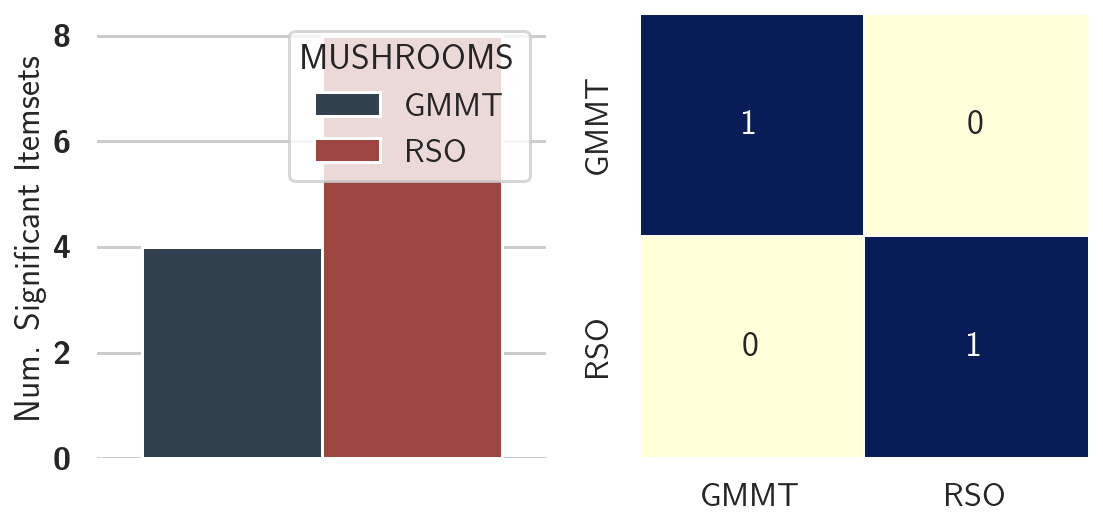

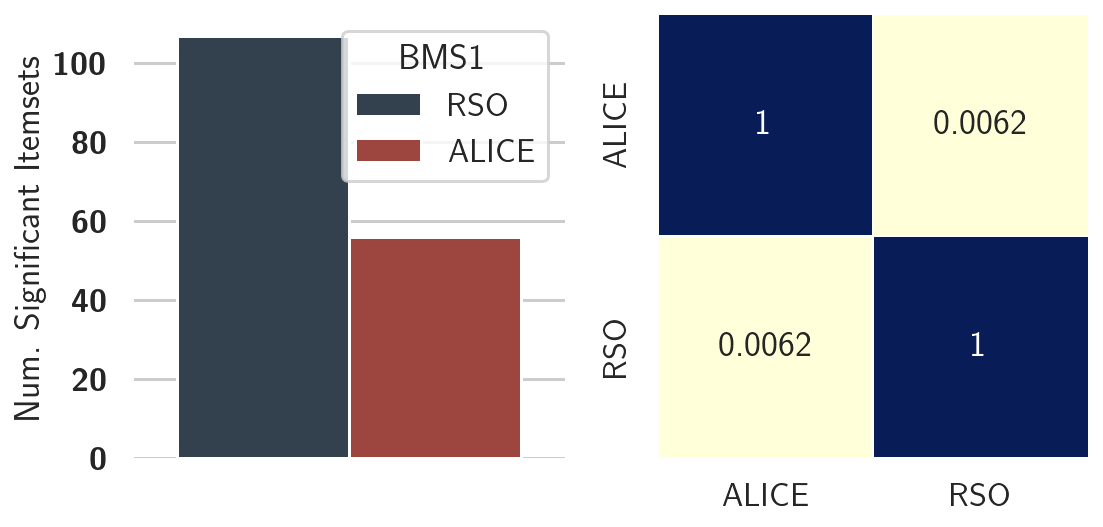

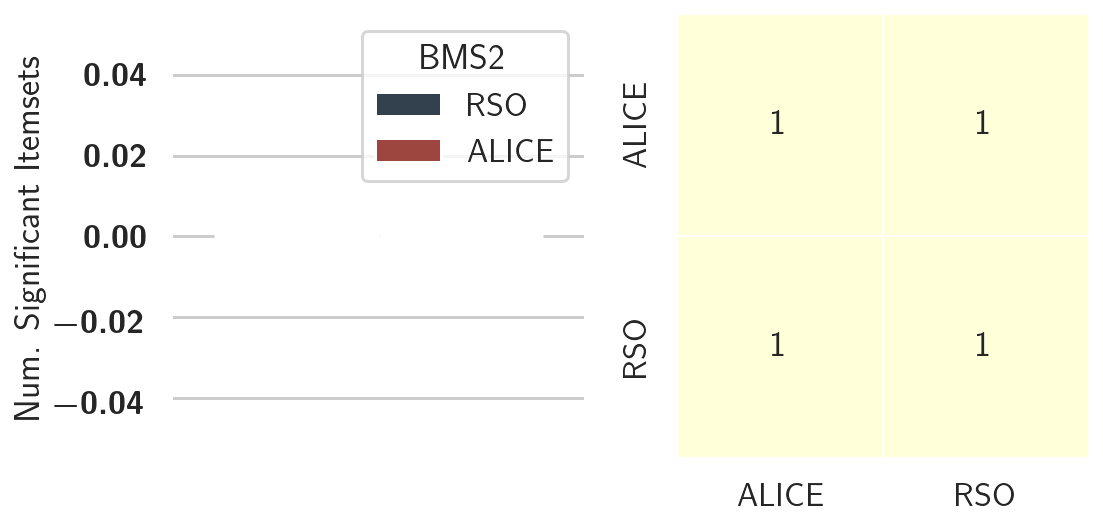

In [43]:
for dataset in sig_df['DataSet'].unique():
    data = sig_df[sig_df['DataSet']==dataset]
    if data.empty: continue
        
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    
    # num significant itemsets
    sns.barplot(data=data, x='DataSet', hue='Algorithm',
            palette=palette, y='NumSignItemsets', ax=ax[0])
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].legend(title=dataset.upper())
    ax[0].set_ylabel('Num. Significant Itemsets')
    ax[0].set_xlabel('')
    ax[0].set_xticklabels('')

    sns.heatmap(data=data.pivot('Algorithm', 'Other', 'Jaccard').fillna(1),
                annot=True, linewidths=1, cmap="YlGnBu", cbar=False, ax=ax[1])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
#     ax[1].set_title('Jaccard')
    plt.tight_layout()
    plt.savefig(fig_dir+f'{dataset}_sigFreqItemsets.pdf')
    plt.show()